# Content
* [1  Problem description](#1)
    * [1.1  Testbed description](#1.1)
    * [1.2  Business problem](#1.2)
    * [1.3  Metrics](#1.3)
    * [1.4  Data description](#1.4)
    * [1.5  Strucuture of data](#1.5)
* [2  Data analysis](#2)
    * [2.1  Data loading](#2.1)
    * [2.2  Summarized information about data](#2.2)
        * [2.2.1  Number of experiements, sizes of datasets](#2.2.1)
        * [2.2.2  Aggregated data for experiments](#2.2.2)
        * [2.2.3  Descriptive statistics](#2.2.3)
        * [2.2.4  Gaps and outliers in data, noise](#2.2.4)
            * [2.2.4.1  Signal plots (data without anomalies)](#2.2.4.1)
            * [2.2.4.2  Correction of current and voltage values](#2.2.4.2)
            * [2.2.4.3  Signal charts (for the entire period)](#2.2.4.3)
            * [2.2.4.4  Charts (data with anomalies)](#2.2.4.4)
        * [2.2.5  Measurement resolution](#2.2.5)
        * [2.2.6  Pairwise Correlations](#2.2.6)
        * [2.2.7  Pairplot](#2.2.7)
        * [2.2.8  Determination of the operation modes: transfer mode, work mode, stop mode](#2.2.8)
    * [2.3  Feature Analysis](#2.3)
        * [2.3.1  Flow rate](#2.3.1)
        * [2.3.2  Vibration acceleration](#2.3.2)
    * [2.4  Assignment for independent work](#2.4)
* [3  Summary](#3)

<a id="1"></a>
# 1 Problem description

<a id="1.1"></a>
## 1.1 Testbed description  

![Стенд](https://github.com/waico/SKAB/blob/master/docs/pictures/testbed.png?raw=true)

Front panel and composition of the water circulation, control and monitoring systems: 1,2 - solenoid valve (amount - 1); 3 - a tank with water (1); 4 - a water pump (1); 5 - emergency stop button (1); 6 - electric motor (1); 7 - inverter (1); 8 - compactRIO (1); 9 - a mechanical lever for shaft misalignment (1). Not shown parts - vibration sensor (2); pressure meter (1); flow meter (1); thermocouple (2).

<a id="1.2"></a>
## 1.2 Business problem

The main advantages of anomaly detection in the operation of equipment:
- Reducing equipment maintenance costs
- Optimization of terms and duration of repair work
- Reducing the probability of failures

<a id="1.3"></a>
## 1.3 Metrics

When an anomaly detection problem is formulated, the classification problem is primarily solved. It is proposed to use the following metrics to evaluate the perfomance of the algorithms:
- False Alarm Rate
$$FAR = \frac{FP}{FP+TN}$$
- Missing Alarm Rate
$$MAR = \frac{FN}{TP+FN}$$

Also, to compare the results of the algorithm, you can consider the metrics described in:
https://tsad.readthedocs.io/en/latest/Evaluating.html 

<a id="1.4"></a>
## 1.4 Data description

Each file represents one experiment and contains one anomaly (the exception is the anomaly-free file, which does not contain any anomalies). The dataset is a multivariate time series collected from testbed sensors. The data folder contains the datasets from the test. Data Folder Structure:

1. anomaly-free - Data obtained from the experiments with normal mode
2. valve1 - Data obtained from the experiments with closing the valve at the outlet of the flow from the pump.
3. valve2 - Data obtained from the experiments with closing the valve at the flow inlet to the pump.
4. other - Data obtained from the other experiments 
> - 13.csv - Sharply behavior of rotor imbalance
> - 14.csv - Linear behavior of rotor imbalance
> - 15.csv - Step behavior of rotor imbalance
> - 16.csv - Dirac delta function behavior of rotor imbalance
> - 17.csv - Exponential behavior of rotor imbalance
> - 18.csv - The slow increase in the amount of water in the circuit
> - 19.csv - The sudden increase in the amount of water in the circuit
> - 20.csv - Draining water from the tank until cavitation
> - 21.csv - Two-phase flow supply to the pump inlet (cavitation)
> - 22.csv - Water supply of increased temperature

<a id="1.5"></a>
## 1.5 Data structure

Columns in each data file are following:
* datetime - Represents dates and times of the moment when the value is written to the database (YYYY-MM-DD hh:mm:ss)
* Accelerometer1RMS - Shows a vibration acceleration (Amount of g units)
* Accelerometer2RMS - Shows a vibration acceleration (Amount of g units)
* Current - Shows the amperage on the electric motor (Ampere)
* Pressure - Represents the pressure in the loop after the water pump (Bar)
* Temperature - Shows the temperature of the engine body (The degree Celsius)
* Thermocouple - Represents the temperature of the fluid in the circulation loop (The degree Celsius)
* Voltage - Shows the voltage on the electric motor (Volt)
* RateRMS - Represents the circulation flow rate of the fluid inside the loop (Liter per minute)
* anomaly - Shows if the point is anomalous (0 or 1)
* changepoint - Shows if the point is a changepoint for collective anomalies (0 or 1)

<a id="2"></a>
# 2 Data analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
# Функции для отрисовки графиков
base_context = 'fivethirtyeight'


def fast_bar(data, figsize=(6, 4), title='', alpha=1, label='', new_figure=True):
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.bar(data.index, data, alpha=alpha, label=label)
        plt.title(title);


def fast_hist(data, n=30, ax=None, figsize=(12, 4), title='', alpha=1, label='', new_figure=True):
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        data.hist(bins=n, ax=ax, figsize=figsize, alpha=alpha, label=label)
        plt.title(title);


def fast_plot(data, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):
    data = data.rolling(rolling).mean()
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(data.index, data, alpha=alpha)
        plt.plot(data.index, data, linewidth=2, label=label)
        if title is not None:
            plt.title(title)


def fast_scatter(x, y, rolling=1, alpha=0.5, figsize=(12, 4), new_figure=True, title=None, label=None):
    x = x.rolling(rolling).mean()
    y = y.rolling(rolling).mean()
    with plt.style.context(base_context):
        if new_figure:
            plt.figure(figsize=figsize)
        plt.scatter(x, y, alpha=alpha, label=label)
        if title is not None:
            plt.title(title)


def fast_legend(ncol=3, pos=(0.5, -0.15), fontsize=16):
    return plt.legend(loc='upper center', ncol=ncol, bbox_to_anchor=pos, fontsize=fontsize)

<a id="2.1"></a>
## 2.1 Data loading

In [3]:
all_files = []
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(f'{root}/{file}')

print("Список файлов:")
all_files.sort()
display(all_files)

Список файлов:


['../data/anomaly-free/anomaly-free.csv',
 '../data/other/11.csv',
 '../data/other/12.csv',
 '../data/other/13.csv',
 '../data/other/14.csv',
 '../data/other/15.csv',
 '../data/other/16.csv',
 '../data/other/17.csv',
 '../data/other/18.csv',
 '../data/other/19.csv',
 '../data/other/20.csv',
 '../data/other/21.csv',
 '../data/other/22.csv',
 '../data/other/23.csv',
 '../data/other/9.csv',
 '../data/valve1/0.csv',
 '../data/valve1/1.csv',
 '../data/valve1/10.csv',
 '../data/valve1/11.csv',
 '../data/valve1/12.csv',
 '../data/valve1/13.csv',
 '../data/valve1/14.csv',
 '../data/valve1/15.csv',
 '../data/valve1/2.csv',
 '../data/valve1/3.csv',
 '../data/valve1/4.csv',
 '../data/valve1/5.csv',
 '../data/valve1/6.csv',
 '../data/valve1/7.csv',
 '../data/valve1/8.csv',
 '../data/valve1/9.csv',
 '../data/valve2/0.csv',
 '../data/valve2/1.csv',
 '../data/valve2/2.csv',
 '../data/valve2/3.csv']

> __TODO:__
> * Obtain a description of the following experiments from the dataowner:
    * 'data/other/9.csv'
    * 'data/other/11.csv',
    * 'data/other/12.csv',
    * 'data/other/23.csv',
    

In [4]:
other_description = ['No description',
                     'No description',
                     'Sharp behavior of rotor unbalance',
                     'Linear behavior of rotor unbalance',
                     'Step behavior of rotor unbalance',
                     'Behavior of the Dirac delta function of rotor unbalance',
                     'Exponential rotor unbalance behavior',
                     'Slow increase in the amount of water in the circuit',
                     'Sudden increase in the amount of water in the circuit',
                     'Draining water from the tank to cavitation',
                     'Feeding a two-phase flow to the pump inlet (cavitation)',
                     'Elevated temperature water supply',
                     'No description',
                     'No description'
                    ]

In [5]:
# Группировка данных по типу аномалии
anomaly_free_data = pd.read_csv('../data/anomaly-free/anomaly-free.csv',
                                sep=';', index_col='datetime', parse_dates=True)
valve1_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve1' in file]
valve2_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file
               in all_files if 'valve2' in file]
other_data = [pd.read_csv(file, sep=';', index_col='datetime', parse_dates=True) for file 
              in all_files if 'other' in file]

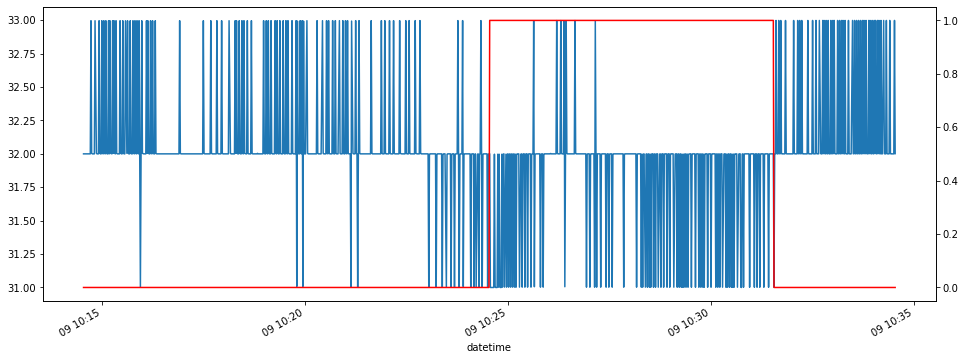

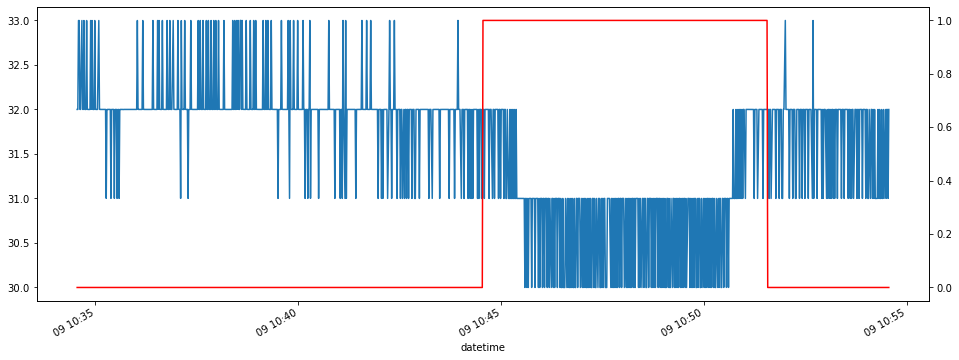

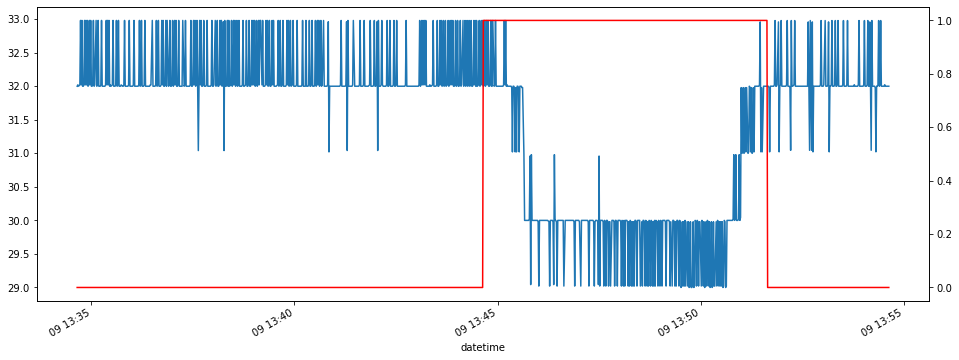

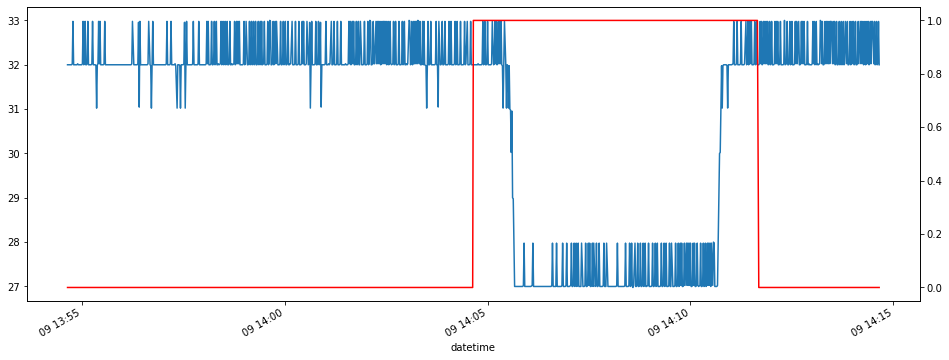

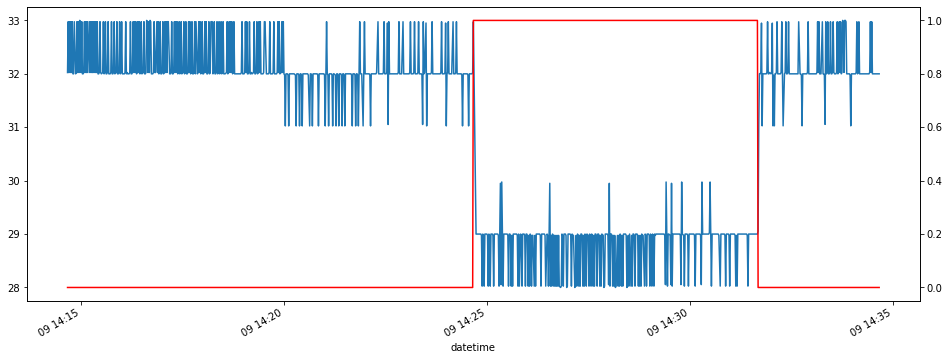

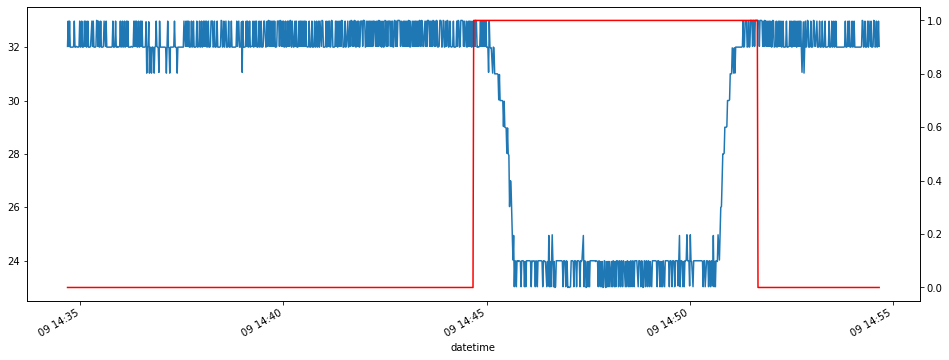

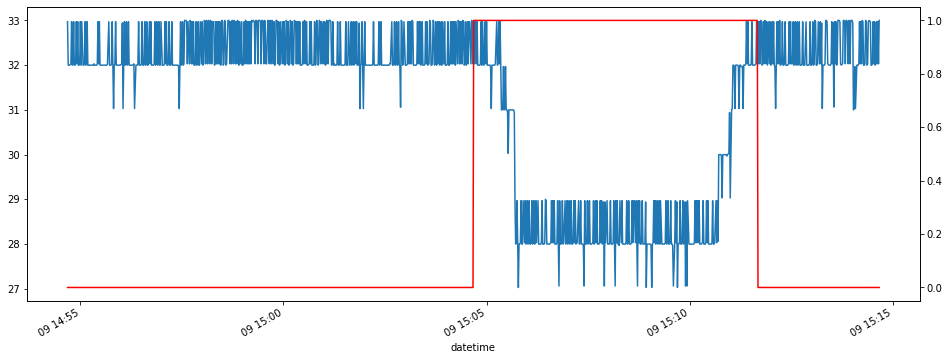

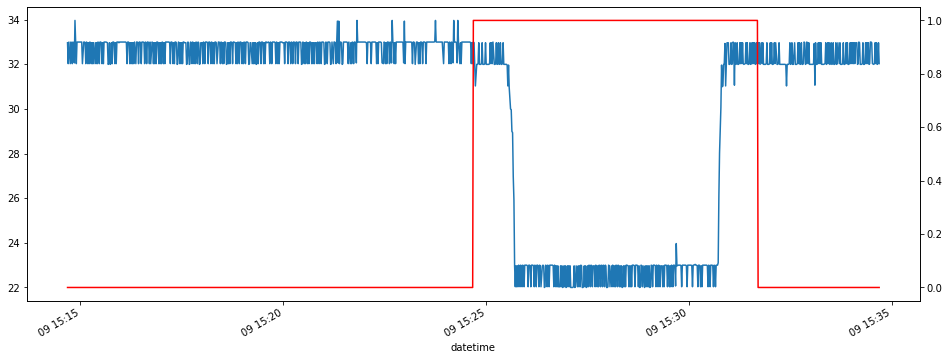

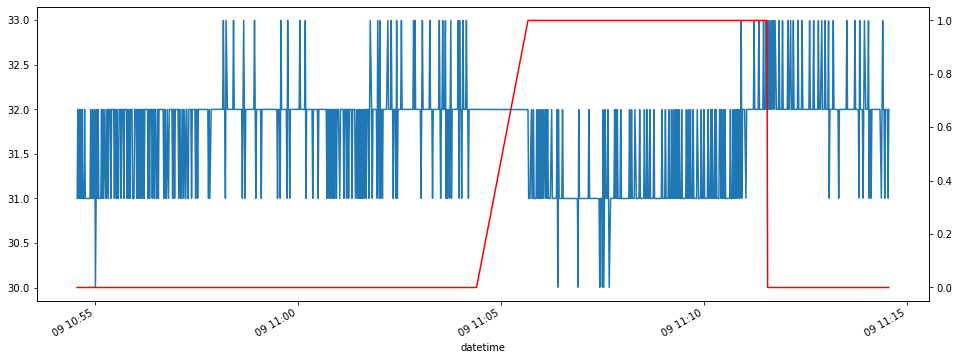

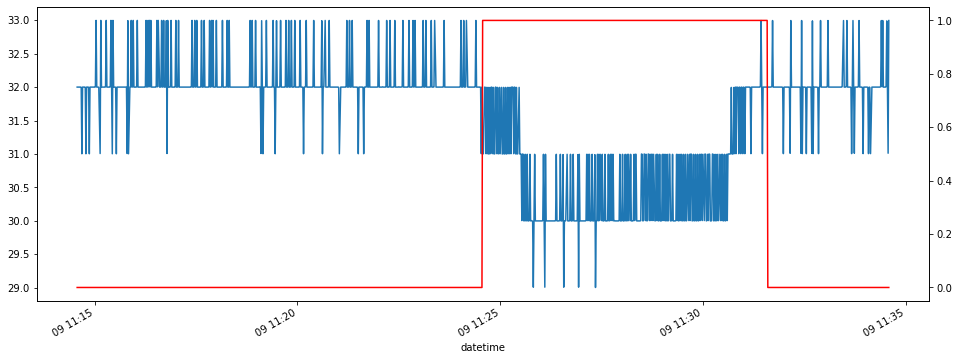

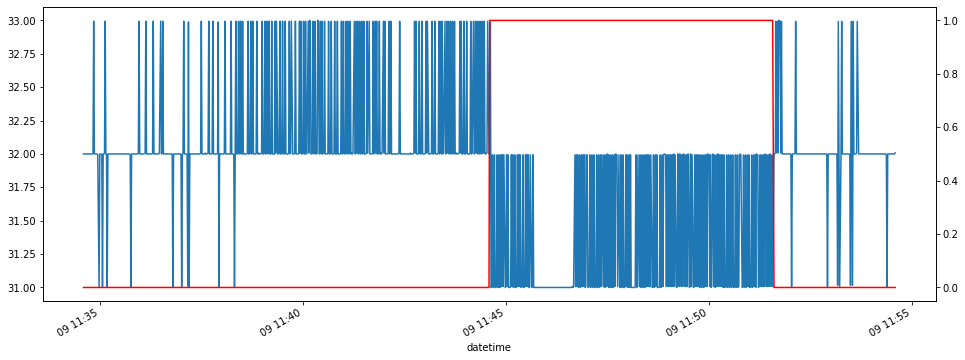

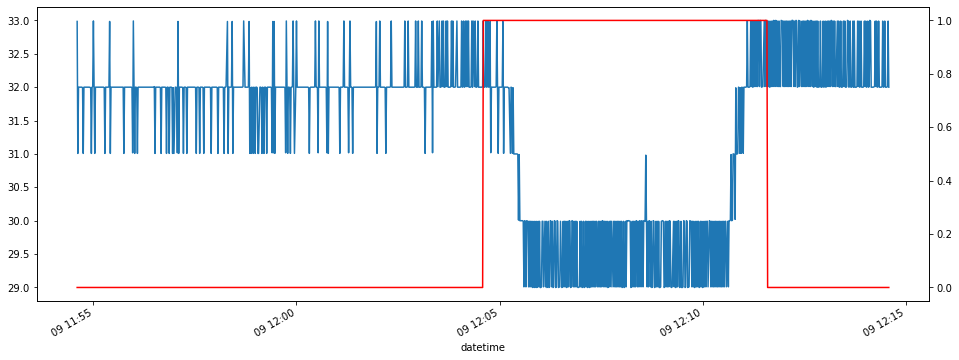

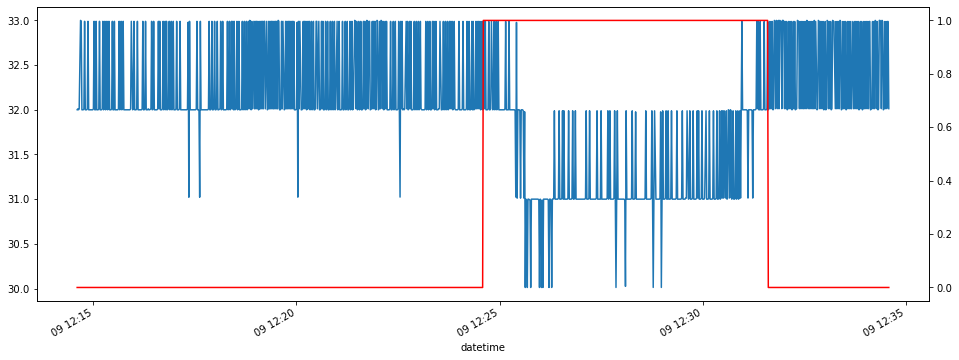

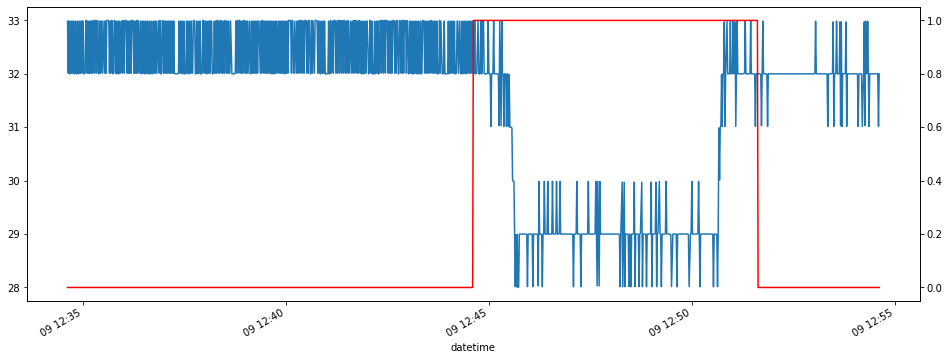

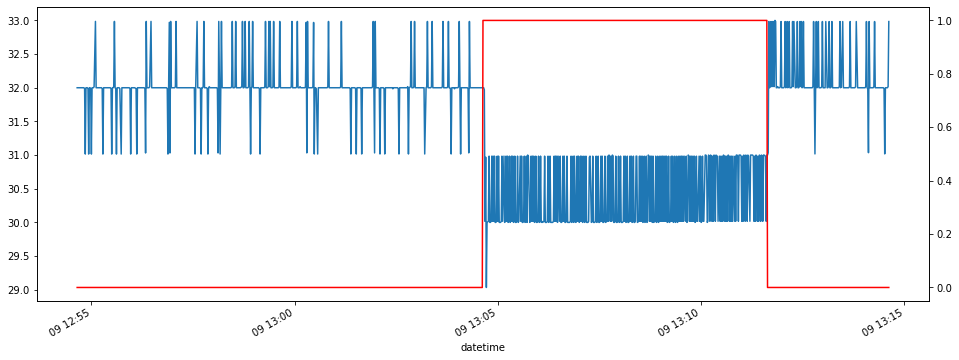

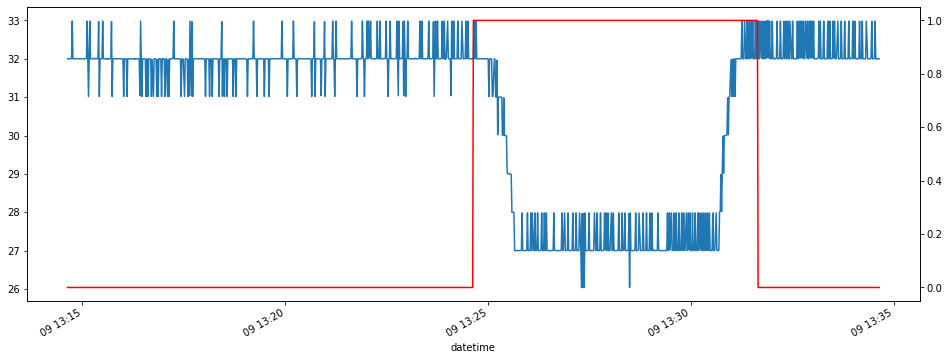

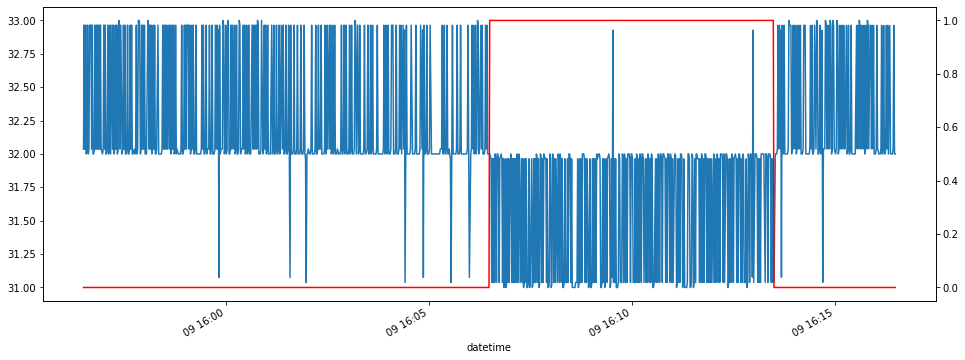

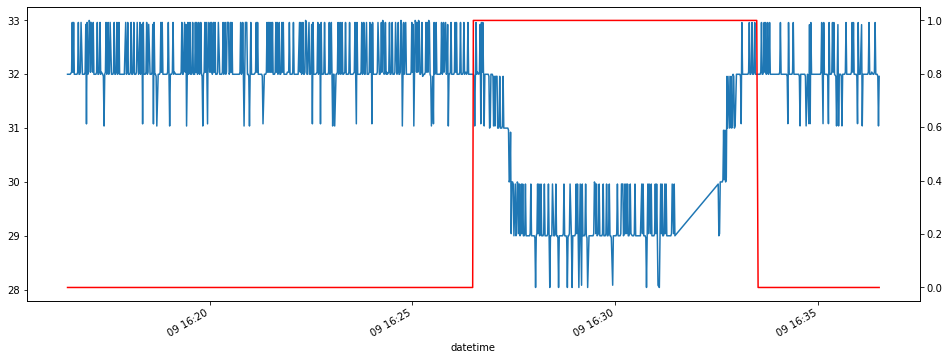

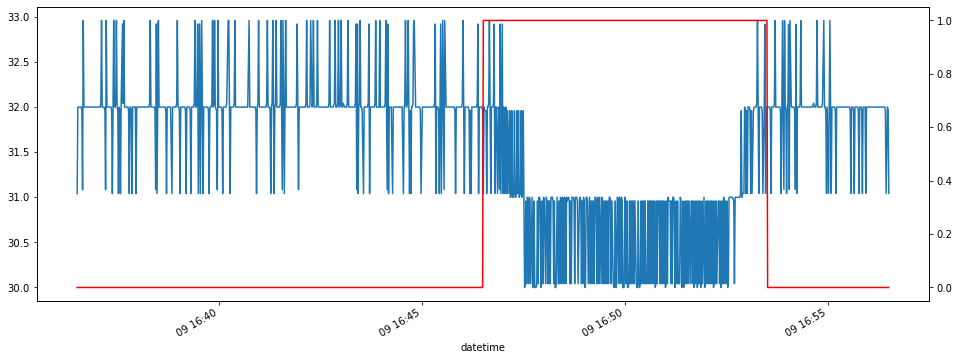

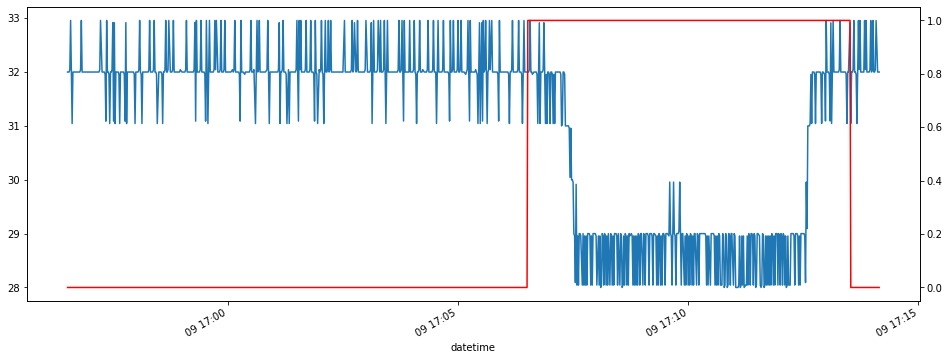

In [11]:
for df in valve1_data + valve2_data :
    plt.figure(figsize=(16,6))
    df['Volume Flow RateRMS'].plot()
    ax = plt.twinx()
    df['anomaly'].plot(ax=ax,c='r')
    plt.show()
#     break
    

In [15]:
len(other_description)

14

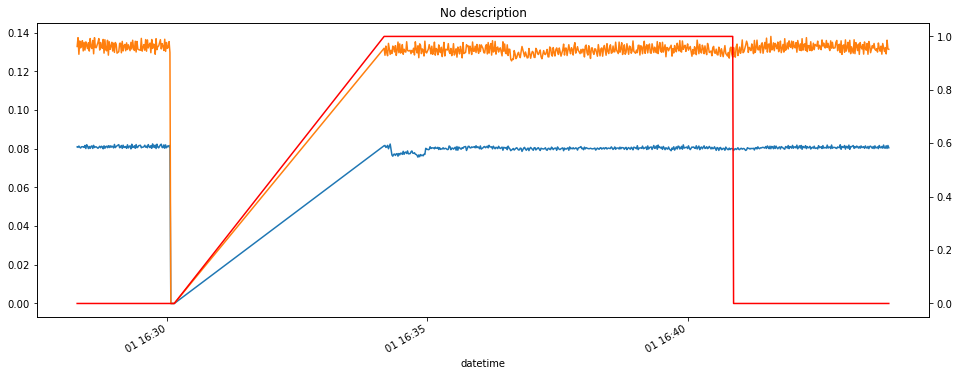

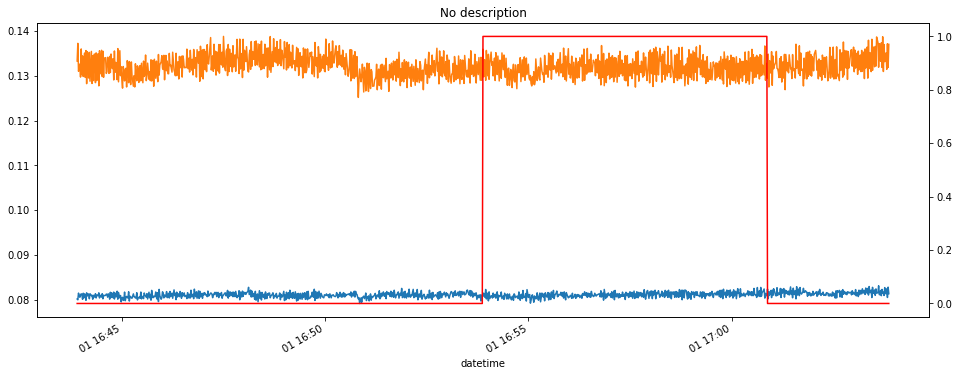

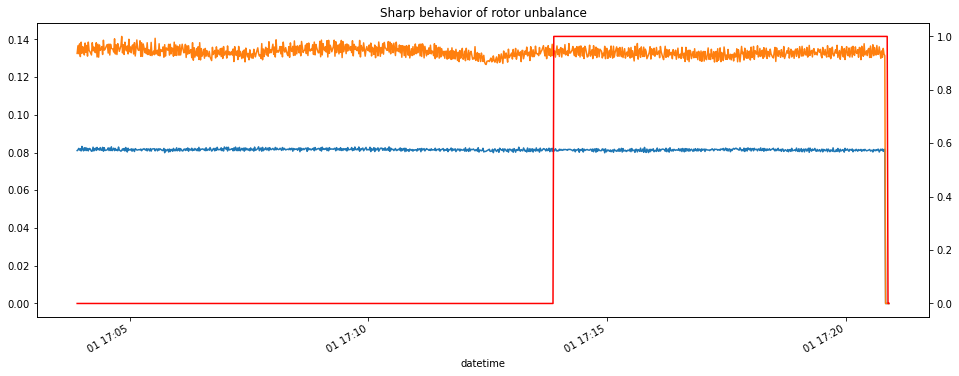

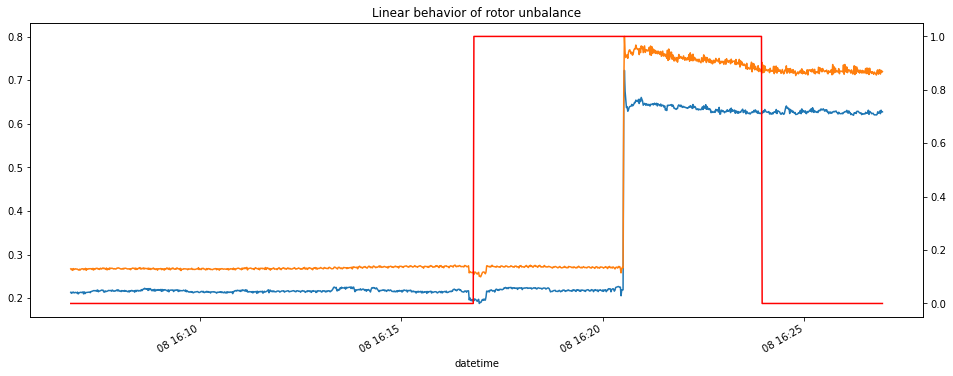

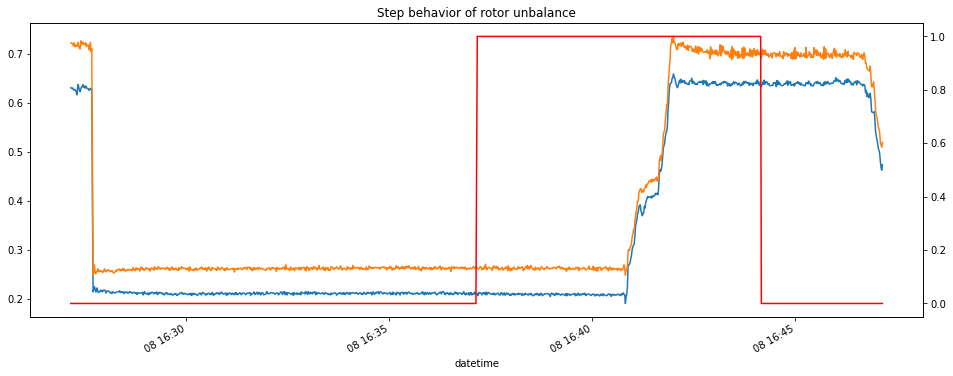

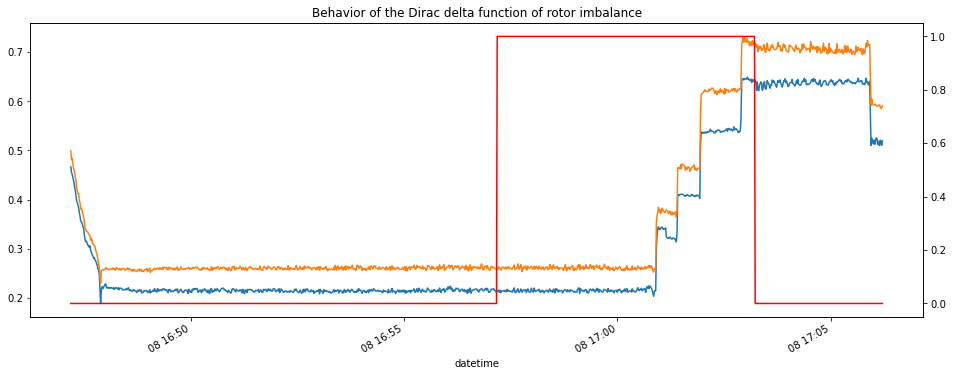

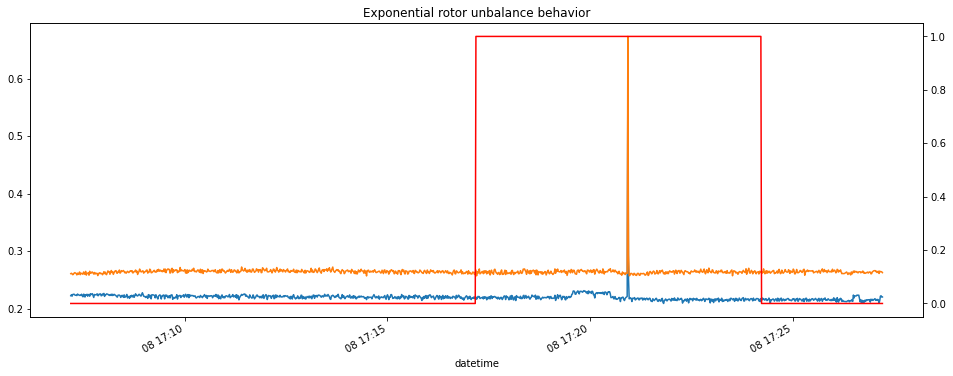

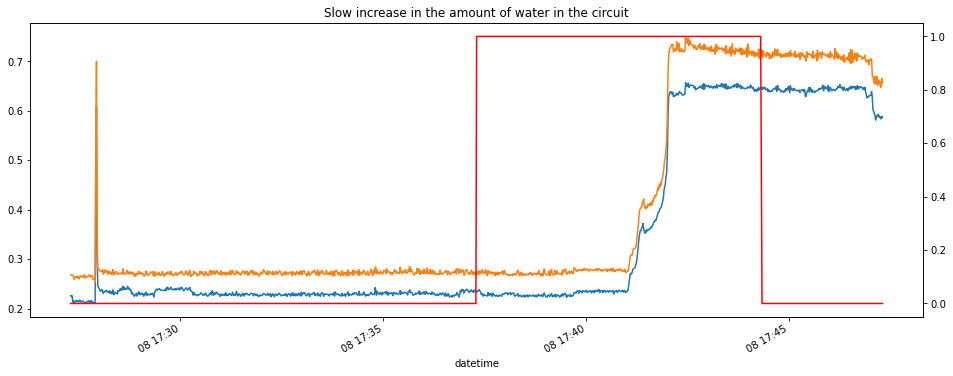

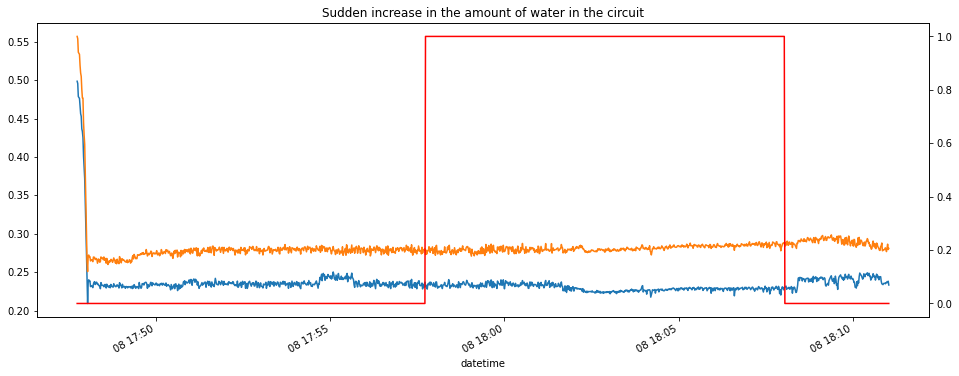

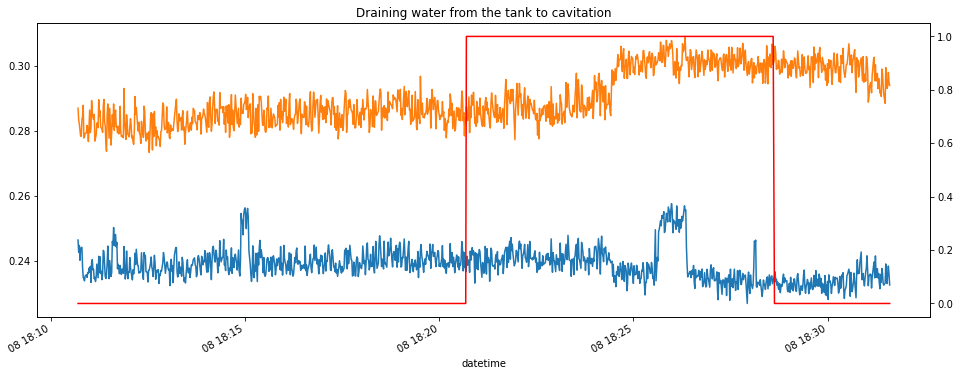

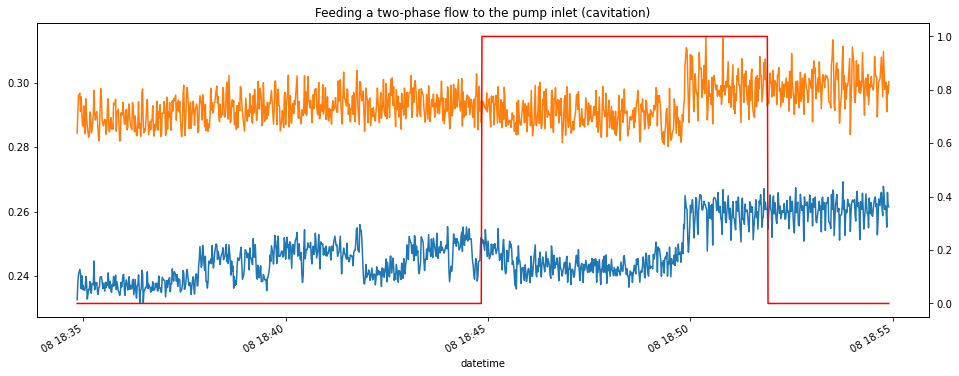

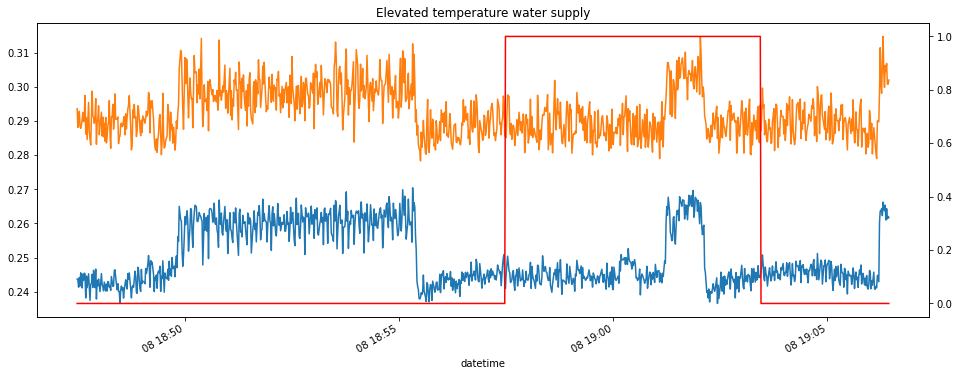

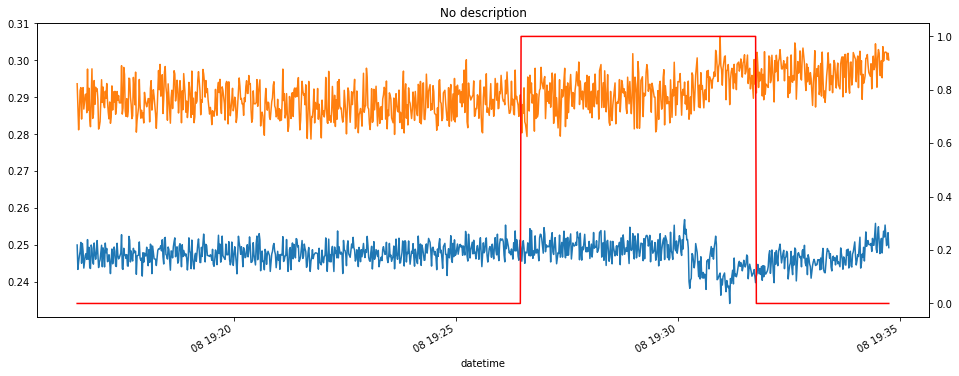

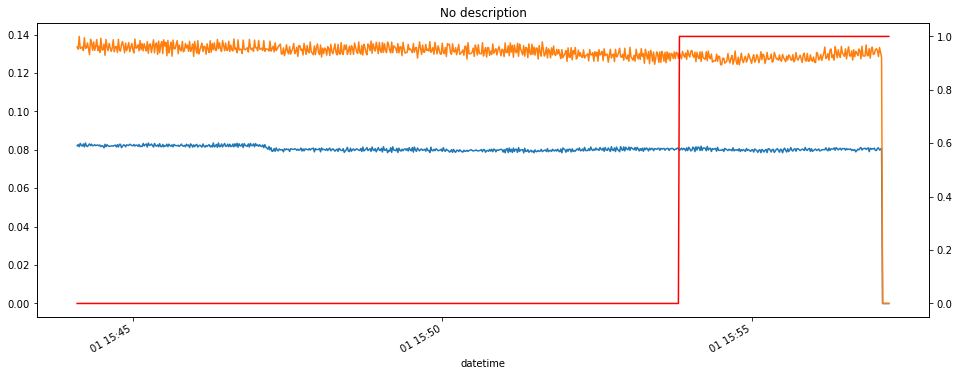

In [14]:
for i,df in enumerate(other_data):
    plt.figure(figsize=(16,6))
    df['Accelerometer1RMS'].plot()
    df['Accelerometer2RMS'].plot()
    ax = plt.twinx()
    df['anomaly'].plot(ax=ax,c='r')
    plt.title(other_description[i])
    plt.show()
#     break

<a id="2.2"></a>
## 2.2 Summarized information about the data
This section focuses on general information about data and contains the following subsections:
* Number of experiments, dataset sizes
* Aggregated experiment data
* Descriptive statistics
* Gaps and outliers in the data
* Measurement resolution
* Pairwise correlations
* Determination of the operation modes: transfer mode, work mode, stop mode

<a id="2.2.1"></a>
### 2.2.1 Number of experiments, dataset sizes
To get started, you can look at the number of experiments in each group, the first few rows in these experiments, and the dimension of the data in the experiments.

In [6]:
display(Markdown('<br>__Number of experiments in each group:__'))
print('Experiments with closing the valve at the outlet of the pump:', len(valve1_data))
print('Experiments with closing the valve at the inlet flow to the pump:', len(valve2_data))
print('Other experiments:', len(other_data))
print('Datasets without anomalies: 1')

display(Markdown('<br><br>__Dataset without anomalies__'))
display(anomaly_free_data.head(3))
print('Dataset size:', anomaly_free_data.shape)

display(Markdown('<br><br>__The first dataset from the group "Other experiments"__'))
display(other_data[0].head(3))
print('Dataset size:', other_data[0].shape)

<br>__Number of experiments in each group:__

Experiments with closing the valve at the outlet of the pump: 16
Experiments with closing the valve at the inlet flow to the pump: 4
Other experiments: 14
Datasets without anomalies: 1


<br><br>__Dataset without anomalies__

Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
datetime                                                                       
2020-02-08 13:30:47           0.206030           0.277924  1.81019  0.382638   
2020-02-08 13:30:48           0.204366           0.275727  2.66317 -0.273216   
2020-02-08 13:30:49           0.206103           0.278526  2.63758  0.382638   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  
datetime                                                                      
2020-02-08 13:30:47      90.1740       26.7760  228.208              121.664  
2020-02-08 13:30:48      90.2836       26.7760  227.245              122.000  
2020-02-08 13:30:49      89.8666       26.7821  237.872              122.000

Dataset size: (9401, 8)


<br><br>__The first dataset from the group "Other experiments"__

Accelerometer1RMS  Accelerometer2RMS   Current  Pressure  \
datetime                                                                        
2020-03-01 16:28:16           0.080968           0.132892  2.078540  0.054711   
2020-03-01 16:28:17           0.080721           0.137438  0.983799  0.710565   
2020-03-01 16:28:18           0.081400           0.128858  1.666630  0.054711   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  \
datetime                                                                       
2020-03-01 16:28:16      88.8333       22.0874  248.524              75.0000   
2020-03-01 16:28:17      88.9111       22.0892  226.593              75.9813   
2020-03-01 16:28:18      88.8676       22.0930  216.814              75.0000   

                     anomaly  changepoint  
datetime                                   
2020-03-01 16:28:16      0.0          0.0  
2020-03-01 16:28:17      0.0          0.0  
2020-03-01 16:28:18      0.0          0.0

Dataset size: (665, 10)


<a id="2.2.2"></a>
### 2.2.2 Aggregated data for experiments
To compare different experiments, we will collect aggregated information for each experiment and create a pivot table that includes the following fields:
* type of experiment
* experiment number
* description of the experiment
* experiment duration
* number of lines
* percentage of rows with anomalies
* number of state change points
* number of gaps in the data
* start and end time of the experiment

In [7]:
def experiment_describe(data, anomaly_type, description, experiment=0):
    start_time = data.index.min()
    finish_time = data.index.max()
    duration = finish_time - start_time
    
    nas = data.isna().sum().sum()
    
    rows = data.shape[0]
    if 'anomaly' in data.columns:
        anomaly_percent = np.round(data['anomaly'].mean() * 100, 2)
        changepoints = data['changepoint'].sum()
    else:
        anomaly_percent = 0
        changepoints = 0  
    
    columns = ['anomaly_type', 'experiment', 'description', 'duration', 'rows', 'anomaly_percent', 'changepoints',
               'Nas', 'start_time', 'finish_time']
    values = np.array([anomaly_type, experiment, description, duration, rows, anomaly_percent, changepoints, nas,
                       start_time, finish_time]).reshape(1, -1)
    
    describe_df = pd.DataFrame(columns=columns, data=values)
    return describe_df


experiment = 1
display(Markdown('<br>__An example of aggregated information for the experiment with the closing of the outlet valve__<br><br>'))
display(experiment_describe(valve1_data[experiment], 'value1', 'Closing the valve downstream of the pump', experiment))

<br>__An example of aggregated information for the experiment with the closing of the outlet valve__<br><br>

anomaly_type experiment                               description  \
0       value1          1  Closing the valve downstream of the pump   

         duration  rows anomaly_percent changepoints Nas          start_time  \
0 0 days 00:20:00  1145           35.11          4.0   0 2020-03-09 10:34:33   

          finish_time  
0 2020-03-09 10:54:33

For this experiment, it can be noted that at a 20-minute interval, the number of records is 1145 - this indicates that there are no value records for some timestamps.

In [8]:
def get_summary_table():
    df = experiment_describe(anomaly_free_data, 'anomaly_free', 'Normal mode')
    
    for experiment in range(len(valve1_data)):
        df = pd.concat([df, experiment_describe(valve1_data[experiment], 'valve1', 
                                                'Closing the valve downstream of the pump', experiment)])
        
    for experiment in range(len(valve2_data)):
        df = pd.concat([df, experiment_describe(valve2_data[experiment], 'valve2',
                                                'Closing the valve at the inlet flow to the pump', experiment)])
        
    for experiment in range(len(other_data)):
        df = pd.concat([df, experiment_describe(other_data[experiment], 'other', other_description[experiment], experiment)])
    
    df.index = [x for x in range(df.shape[0])]
    return df

summary_table = get_summary_table()
display(Markdown('<br>__Summary table for all experiments__<br><br>'))
display(summary_table)

# Склеиваем все эксперименты в один список
dfs = [anomaly_free_data] + valve1_data + valve2_data + other_data

<br>__Summary table for all experiments__<br><br>

anomaly_type experiment  \
0   anomaly_free          0   
1         valve1          0   
2         valve1          1   
3         valve1          2   
4         valve1          3   
5         valve1          4   
6         valve1          5   
7         valve1          6   
8         valve1          7   
9         valve1          8   
10        valve1          9   
11        valve1         10   
12        valve1         11   
13        valve1         12   
14        valve1         13   
15        valve1         14   
16        valve1         15   
17        valve2          0   
18        valve2          1   
19        valve2          2   
20        valve2          3   
21         other          0   
22         other          1   
23         other          2   
24         other          3   
25         other          4   
26         other          5   
27         other          6   
28         other          7   
29         other          8   
30         other          9   
31         other         10   
32         other         11   
33         other         12   
34         other         13   

                                          description        duration  rows  \
0                                         Normal mode 0 days 02:46:00  9401   
1            Closing the valve downstream of the pump 0 days 00:19:59  1148   
2            Closing the valve downstream of the pump 0 days 00:20:00  1145   
3            Closing the valve downstream of the pump 0 days 00:19:59  1146   
4            Closing the valve downstream of the pump 0 days 00:20:00  1141   
5            Closing the valve downstream of the pump 0 days 00:20:00  1140   
6            Closing the valve downstream of the pump 0 days 00:19:59  1140   
7            Closing the valve downstream of the pump 0 days 00:19:59  1139   
8            Closing the valve downstream of the pump 0 days 00:20:00  1150   
9            Closing the valve downstream of the pump 0 days 00:19:59  1075   
10           Closing the valve downstream of the pump 0 days 00:20:01  1149   
11           Closing the valve downstream of the pump 0 days 00:19:59  1095   
12           Closing the valve downstream of the pump 0 days 00:19:59  1154   
13           Closing the valve downstream of the pump 0 days 00:19:59  1154   
14           Closing the valve downstream of the pump 0 days 00:20:00  1094   
15           Closing the valve downstream of the pump 0 days 00:19:58  1144   
16           Closing the valve downstream of the pump 0 days 00:20:00  1148   
17    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1125   
18    Closing the valve at the inlet flow to the pump 0 days 00:20:00  1063   
19    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1129   
20    Closing the valve at the inlet flow to the pump 0 days 00:17:38   995   
21                                     No description 0 days 00:15:36   665   
22                                     No description 0 days 00:19:58  1137   
23                  Sharp behavior of rotor unbalance 0 days 00:17:00   968   
24                 Linear behavior of rotor unbalance 0 days 00:20:08  1153   
25                   Step behavior of rotor unbalance 0 days 00:20:00  1147   
26  Behavior of the Dirac delta function of rotor ... 0 days 00:19:02  1091   
27               Exponential rotor unbalance behavior 0 days 00:20:02  1147   
28  Slow increase in the amount of water in the ci... 0 days 00:20:00  1145   
29  Sudden increase in the amount of water in the ... 0 days 00:23:18  1326   
30         Draining water from the tank to cavitation 0 days 00:20:54  1191   
31  Feeding a two-phase flow to the pump inlet (ca... 0 days 00:20:03  1141   
32                  Elevated temperature water supply 0 days 00:18:57  1079   
33                                     No description 0 days 00:18:17  1044   
34                                     No description 0 days 00:13:07   751   

   anomaly_percent changepoints Nas       

__From this table, the following can be noted:__
* The target time for experiments is about 20 minutes, for anomaly_free the time was 2 hours 46 minutes
* The percentage of time with an abnormal mode is in the range from 25.83% to 57.74%, but for the main part, this value is in the region of 35%
* For most experiments, 4 state change points are recorded
* np.NaN values are missing in the data
* Experiments were carried out on the following dates: 2020-02-08, 2020-03-01, 2020-03-09

<a id="2.2.3"></a>
### 2.2.3 Descriptive statistics
To further familiarize yourself with the data, you can display descriptive statistics for one of the experiments.
They include the following fields:
* count - number of records that are not gaps (np.NaN)
* minimum, average, maximum values, median and 25 75 percentiles
* standard deviation

In [9]:
display(anomaly_free_data.describe().T)

count        mean        std         min         25%  \
Accelerometer1RMS    9401.0    0.212277   0.004728    0.193992    0.210431   
Accelerometer2RMS    9401.0    0.268553   0.004129    0.248062    0.265524   
Current              9401.0    2.568057   6.082034    0.855284    2.129540   
Pressure             9401.0    0.111429   0.252583   -1.257000    0.054711   
Temperature          9401.0   89.506955   0.673482   88.171300   88.974200   
Thermocouple         9401.0   28.417508   0.757808   26.765800   27.841900   
Voltage              9401.0  228.490887  12.579837    1.036640  222.625000   
Volume Flow RateRMS  9401.0  125.140908   1.671961  118.000000  124.000000   

                            50%         75%         max  
Accelerometer1RMS      0.212928    0.215262    0.225967  
Accelerometer2RMS      0.267378    0.271934    0.280214  
Current                2.541080    2.728380  233.203000  
Pressure               0.054711    0.382638    1.366420  
Temperature           89.380500   89.922400   91.724900  
Thermocouple          28.624800   29.068500   29.522100  
Voltage              228.942000  234.963000  252.806000  
Volume Flow RateRMS  125.672000  126.328000  128.353000

__The following points can be distinguished from the table:__
* Negative values have been observed for pressure (min = -1.257000)
* The standard deviation of the current is above its average value



To compare experiments from different groups, you can calculate the average value and standard deviations of each of the parameters

In [10]:
columns = anomaly_free_data.columns
mean_table = pd.DataFrame(index=[x + ' mean' for x in columns])
mean_table['anomaly free'] = anomaly_free_data.describe().loc['mean'].values
mean_table['valve1[0]'] = valve1_data[0][columns].describe().loc['mean'].values
mean_table['valve2[0]'] = valve2_data[0][columns].describe().loc['mean'].values
mean_table['other[0]'] = other_data[0][columns].describe().loc['mean'].values

std_table = pd.DataFrame(index=[x + ' std' for x in columns])
std_table['anomaly free'] = anomaly_free_data.describe().loc['std'].values
std_table['valve1[0]'] = valve1_data[0][columns].describe().loc['std'].values
std_table['valve2[0]'] = valve2_data[0][columns].describe().loc['std'].values
std_table['other[0]'] = other_data[0][columns].describe().loc['std'].values

std_mean_table = pd.concat([mean_table, std_table,])
display(std_mean_table)

anomaly free   valve1[0]   valve2[0]    other[0]
Accelerometer1RMS mean        0.212277    0.026521    0.027595    0.079733
Accelerometer2RMS mean        0.268553    0.040173    0.039414    0.130707
Current mean                  2.568057    1.409799    1.578356    1.926646
Pressure mean                 0.111429    0.084133    0.038971    0.002440
Temperature mean             89.506955   77.437466   68.759219   87.953613
Thermocouple mean            28.417508   25.958166   24.329524   22.101079
Voltage mean                228.490887  230.322345  230.316765  230.308699
Volume Flow RateRMS mean    125.140908   32.021791   32.038678   74.541546
Accelerometer1RMS std         0.004728    0.000329    0.000365    0.007020
Accelerometer2RMS std         0.004129    0.000773    0.001030    0.011649
Current std                   6.082034    9.712153   11.757032    8.932977
Pressure std                  0.252583    0.249460    0.260521    0.263618
Temperature std               0.673482    1.745231    1.442933    0.670718
Thermocouple std              0.757808    0.078422    0.030782    0.018344
Voltage std                  12.579837   15.910242   16.051073   13.904155
Volume Flow RateRMS std       1.671961    0.458517    0.584108    6.631012

__From this table, the following points can be distinguished:__
* The average value of vibration acceleration for anomaly free is almost an order of magnitude higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])
* The average water flow rate for anomaly free is 4 times higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])
* Average values of temperature, pressure, current, thermocouple for anomaly free are higher than for experiments with closing inlet and outlet valves (valve1[0], valve2[0])

<a id="2.2.4"></a>
### 2.2.4 Gaps and outliers in data, noise
It is not always possible to detect gaps in the data using the pandas isna() method. Data gaps can be denoted by 0 or other values. Let's evaluate the presence of gaps and outliers using graphs.

<a id="2.2.4.1"></a>
#### 2.2.4.1 Signal plots (data without anomalies)
To evaluate gaps, spikes and noise, we will display trend graphs for each signal

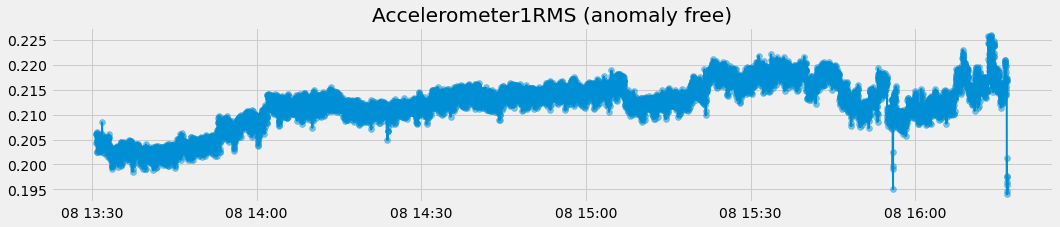

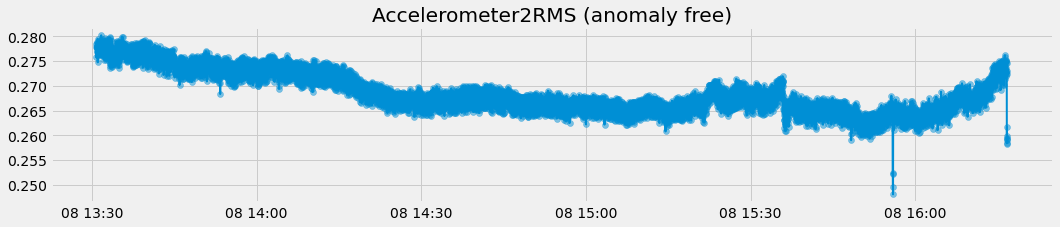

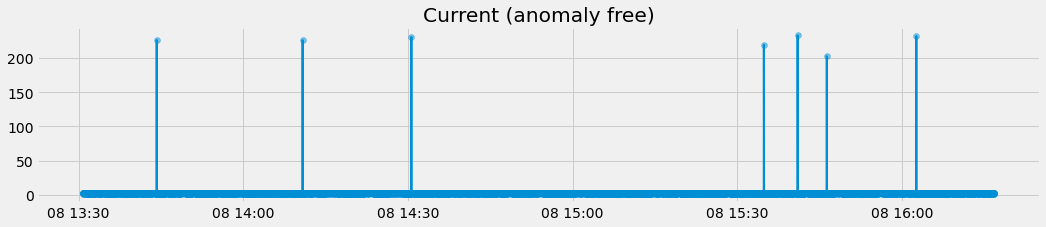

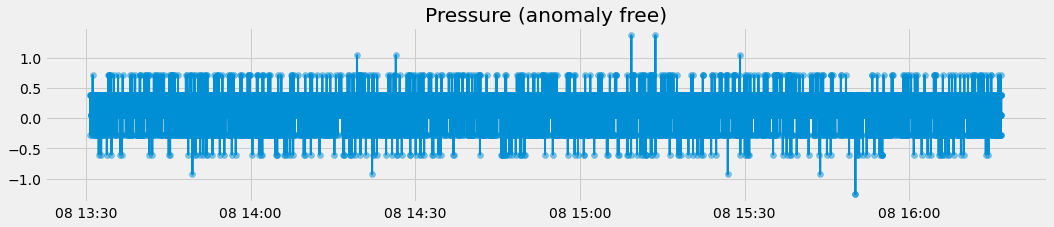

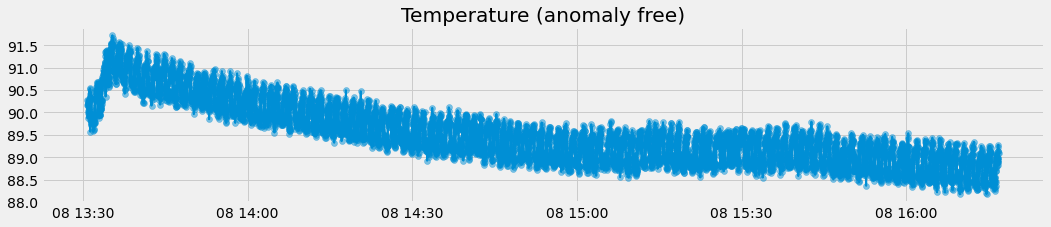

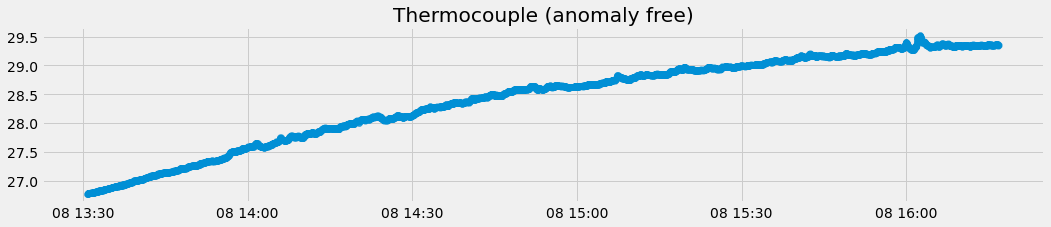

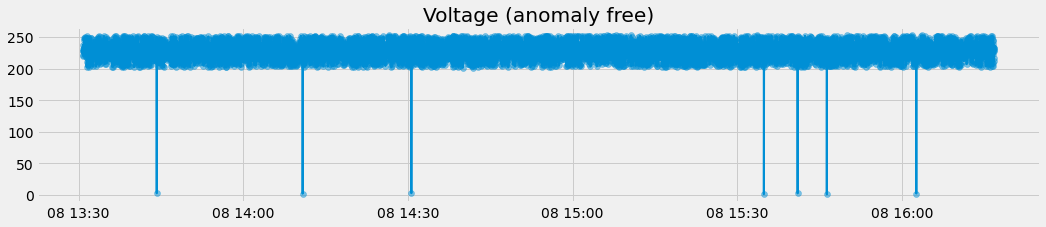

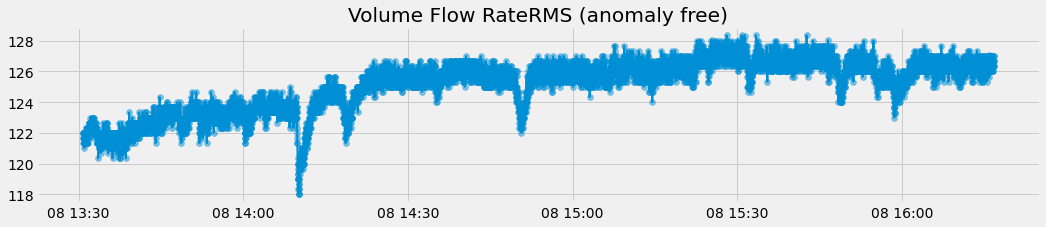

In [11]:
for column in anomaly_free_data.columns:
    fast_plot(anomaly_free_data[column], title=column + ' (anomaly free)', figsize=(16, 3))

On the graphs of vibration accelerations, current and voltage, strong outliers are observed.

Drawdowns are visible on the consumption graphs.

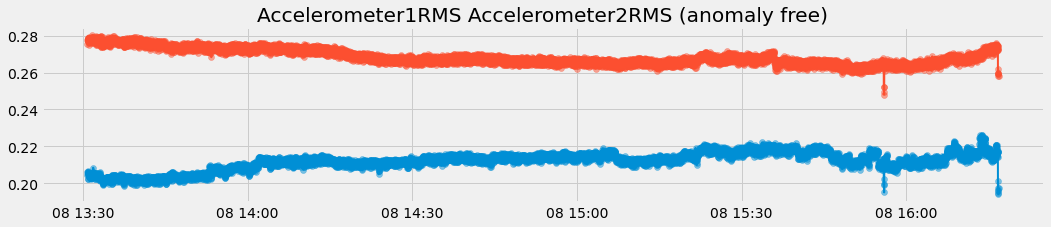

In [12]:
fast_plot(anomaly_free_data['Accelerometer1RMS'], title='Accelerometer1RMS Accelerometer2RMS (anomaly free)', figsize=(16, 3))
fast_plot(anomaly_free_data['Accelerometer2RMS'], figsize=(14, 3), new_figure=False)

>__Questions:__
> * What can drawdowns in terms of flow rate and vibration accelerations be associated with?

> __Hypotheses:__
> * Periods in which there is a drop in consumption must be excluded from the dataset when training models

Let's take a closer look at current surges - filter the data according to the condition Current < 50. And display the current and voltage graphs after filtering.

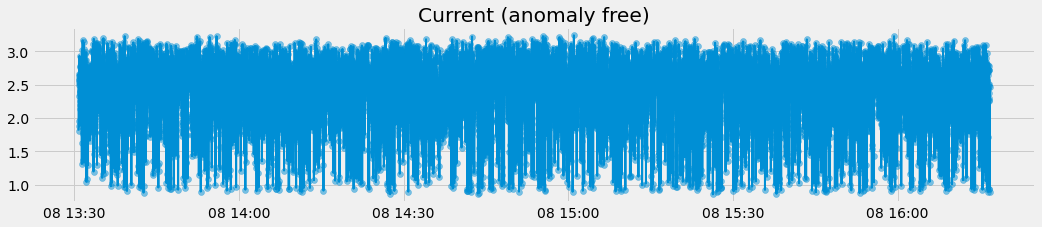

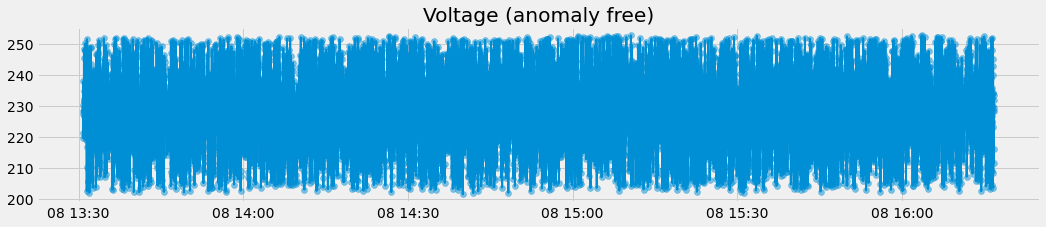

In [13]:
mask = anomaly_free_data['Current'] < 50
fast_plot(anomaly_free_data['Current'][mask], title='Current (anomaly free)', figsize=(16, 3))
plt.show()
fast_plot(anomaly_free_data['Voltage'][mask], title='Voltage (anomaly free)', figsize=(16, 3))
plt.show()

As you can see, after filtering, the current is in the range of ~1-3, and the voltage is ~200-250. Let's take a closer look at the values in the filtered points and the value of +-5 seconds from the first filtered point (2020-02-08 13:44:14).

In [14]:
display(anomaly_free_data[~mask])
display(anomaly_free_data['2020-02-08 13:44:10': '2020-02-08 13:44:20'])

Accelerometer1RMS  Accelerometer2RMS  Current  Pressure  \
datetime                                                                       
2020-02-08 13:44:14           0.203592           0.274729  226.503  0.710565   
2020-02-08 14:10:49           0.210095           0.271741  226.281  0.710565   
2020-02-08 14:30:38           0.212057           0.266588  230.819  0.054711   
2020-02-08 15:34:51           0.217426           0.268239  219.403  0.382638   
2020-02-08 15:41:00           0.217812           0.265362  233.203  0.382638   
2020-02-08 15:46:19           0.213642           0.266691  202.809  0.054711   
2020-02-08 16:02:38           0.211430           0.265437  232.028  0.054711   

                     Temperature  Thermocouple  Voltage  Volume Flow RateRMS  
datetime                                                                      
2020-02-08 13:44:14      90.8761       27.1287  2.71168              122.337  
2020-02-08 14:10:49      89.6471       27.8253  2.09708              119.670  
2020-02-08 14:30:38      89.2359       28.1778  2.79663              125.669  
2020-02-08 15:34:51      89.4128       29.0579  1.33638              126.675  
2020-02-08 15:41:00      89.3436       29.1639  2.54704              127.000  
2020-02-08 15:46:19      88.7889       29.1755  1.03664              127.000  
2020-02-08 16:02:38      88.6294       29.4888  2.37402              126.677

Accelerometer1RMS  Accelerometer2RMS    Current  \
datetime                                                               
2020-02-08 13:44:10           0.202876           0.274772    2.72626   
2020-02-08 13:44:11           0.201115           0.275700    1.75323   
2020-02-08 13:44:12           0.203349           0.274245    2.80654   
2020-02-08 13:44:13           0.200157           0.275363    2.73539   
2020-02-08 13:44:14           0.203592           0.274729  226.50300   
2020-02-08 13:44:15           0.200596           0.275291    2.24085   
2020-02-08 13:44:17           0.203151           0.274941    2.64417   
2020-02-08 13:44:18           0.201706           0.273778    2.70000   
2020-02-08 13:44:19           0.202398           0.276735    2.64861   
2020-02-08 13:44:20           0.202347           0.272765    3.03909   

                     Pressure  Temperature  Thermocouple    Voltage  \
datetime                                                              
2020-02-08 13:44:10  0.382638      90.5533       27.1310  235.63600   
2020-02-08 13:44:11  0.054711      90.5299       27.1262  223.10400   
2020-02-08 13:44:12  0.054711      90.6103       27.1262  250.46600   
2020-02-08 13:44:13  0.054711      90.2552       27.1225  232.03200   
2020-02-08 13:44:14  0.710565      90.8761       27.1287    2.71168   
2020-02-08 13:44:15  0.382638      90.6862       27.1249  214.37800   
2020-02-08 13:44:17  0.382638      90.5583       27.1298  226.85600   
2020-02-08 13:44:18  0.054711      90.4567       27.1294  233.01600   
2020-02-08 13:44:19  0.054711      90.4516       27.1336  228.52800   
2020-02-08 13:44:20  0.054711      90.9855       27.1336  241.31300   

                     Volume Flow RateRMS  
datetime                                  
2020-02-08 13:44:10              122.000  
2020-02-08 13:44:11              122.665  
2020-02-08 13:44:12              123.000  
2020-02-08 13:44:13              123.000  
2020-02-08 13:44:14              122.337  
2020-02-08 13:44:15              122.665  
2020-02-08 13:44:17              122.337  
2020-02-08 13:44:18              122.665  
2020-02-08 13:44:19              123.000  
2020-02-08 13:44:20              123.000

As we can see at the moment of time 2020-02-08 13:44:14, the current and voltage values ​​seem to change places for 1 second

>__Questions:__
> * What could be the reason for the substitution of current and voltage values? Can be corrected?

<a id="2.2.4.2"></a>
#### 2.2.4.2 Correction of current and voltage values
Let's correct the values of current and voltage according to the following condition - if the current is greater than 100 and the voltage is less than 100, then the values are reversed

In [15]:
anomaly_free_data_corrected = anomaly_free_data.copy()
mask = (anomaly_free_data['Current'] > 100) & (anomaly_free_data['Voltage'] < 100)
anomaly_free_data_corrected['Current'][mask] = anomaly_free_data['Voltage'][mask]
anomaly_free_data_corrected['Voltage'][mask] = anomaly_free_data['Current'][mask]

In [16]:
columns = ['Current', 'Voltage']
std_table = pd.DataFrame(index=[x + ' std' for x in columns])
std_table['anomaly free'] = anomaly_free_data[columns].describe().loc['std'].values
std_table['anomaly free corrected'] = anomaly_free_data_corrected[columns].describe().loc['std'].values

mean_table = pd.DataFrame(index=[x + ' mean' for x in columns])
mean_table['anomaly free'] = anomaly_free_data[columns].describe().loc['mean'].values
mean_table['anomaly free corrected'] = anomaly_free_data_corrected[columns].describe().loc['mean'].values

std_mean_table = pd.concat([std_table, mean_table])
display(std_mean_table)

anomaly free  anomaly free corrected
Current std       6.082034                0.485134
Voltage std      12.579837               10.961358
Current mean      2.568057                2.402528
Voltage mean    228.490887              228.656417

As you can see, after the correction, the standard deviation for the current decreased by an order of magnitude.

Let's see how many points can be corrected in this way in each experiment

In [17]:
summary_table['Value_Swap'] = 0
for i in range(len(dfs)):
    summary_table.loc[i, 'Value_Swap'] = ((dfs[i]['Current'] > 100) & (dfs[i]['Voltage'] < 100)).sum()
    
summary_table

anomaly_type experiment  \
0   anomaly_free          0   
1         valve1          0   
2         valve1          1   
3         valve1          2   
4         valve1          3   
5         valve1          4   
6         valve1          5   
7         valve1          6   
8         valve1          7   
9         valve1          8   
10        valve1          9   
11        valve1         10   
12        valve1         11   
13        valve1         12   
14        valve1         13   
15        valve1         14   
16        valve1         15   
17        valve2          0   
18        valve2          1   
19        valve2          2   
20        valve2          3   
21         other          0   
22         other          1   
23         other          2   
24         other          3   
25         other          4   
26         other          5   
27         other          6   
28         other          7   
29         other          8   
30         other          9   
31         other         10   
32         other         11   
33         other         12   
34         other         13   

                                          description        duration  rows  \
0                                         Normal mode 0 days 02:46:00  9401   
1            Closing the valve downstream of the pump 0 days 00:19:59  1148   
2            Closing the valve downstream of the pump 0 days 00:20:00  1145   
3            Closing the valve downstream of the pump 0 days 00:19:59  1146   
4            Closing the valve downstream of the pump 0 days 00:20:00  1141   
5            Closing the valve downstream of the pump 0 days 00:20:00  1140   
6            Closing the valve downstream of the pump 0 days 00:19:59  1140   
7            Closing the valve downstream of the pump 0 days 00:19:59  1139   
8            Closing the valve downstream of the pump 0 days 00:20:00  1150   
9            Closing the valve downstream of the pump 0 days 00:19:59  1075   
10           Closing the valve downstream of the pump 0 days 00:20:01  1149   
11           Closing the valve downstream of the pump 0 days 00:19:59  1095   
12           Closing the valve downstream of the pump 0 days 00:19:59  1154   
13           Closing the valve downstream of the pump 0 days 00:19:59  1154   
14           Closing the valve downstream of the pump 0 days 00:20:00  1094   
15           Closing the valve downstream of the pump 0 days 00:19:58  1144   
16           Closing the valve downstream of the pump 0 days 00:20:00  1148   
17    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1125   
18    Closing the valve at the inlet flow to the pump 0 days 00:20:00  1063   
19    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1129   
20    Closing the valve at the inlet flow to the pump 0 days 00:17:38   995   
21                                     No description 0 days 00:15:36   665   
22                                     No description 0 days 00:19:58  1137   
23                  Sharp behavior of rotor unbalance 0 days 00:17:00   968   
24                 Linear behavior of rotor unbalance 0 days 00:20:08  1153   
25                   Step behavior of rotor unbalance 0 days 00:20:00  1147   
26  Behavior of the Dirac delta function of rotor ... 0 days 00:19:02  1091   
27               Exponential rotor unbalance behavior 0 days 00:20:02  1147   
28  Slow increase in the amount of water in the ci... 0 days 00:20:00  1145   
29  Sudden increase in the amount of water in the ... 0 days 00:23:18  1326   
30         Draining water from the tank to cavitation 0 days 00:20:54  1191   
31  Feeding a two-phase flow to the pump inlet (ca... 0 days 00:20:03  1141   
32                  Elevated temperature water supply 0 days 00:18:57  1079   
33                                     No description 0 days 00:18:17  1044   
34                                     No description 0 days 00:13:07   751   

   anomaly_percent changepoints Nas       

In [18]:
# Correction function
def current_voltage_correction(data):
    data = data.copy()
    mask = (data['Current'] > 100) & (data['Voltage'] < 100)
    idx = mask[mask].index
    
    voltage = data['Current'][mask]
    current = data['Voltage'][mask]
    data.loc[idx, 'Current'] = current
    data.loc[idx,'Voltage'] = voltage
    return data

In [19]:
for i in range(len(dfs)):
    dfs[i] = current_voltage_correction(dfs[i])
    
for i in range(len(valve1_data)):
    valve1_data[i] = current_voltage_correction(valve1_data[i])
    
for i in range(len(valve2_data)):
    valve2_data[i] = current_voltage_correction(valve2_data[i])
    
for i in range(len(other_data)):
    other_data[i] = current_voltage_correction(other_data[i])

> __TODO:__
> * Add current and voltage regulation characteristics to data preprocessing

<a id="2.2.4.3"></a>
#### 2.2.4.3 Signal charts (for the whole period)
To search for trends and other patterns in the data, let's see how the signal values behave over the entire available period

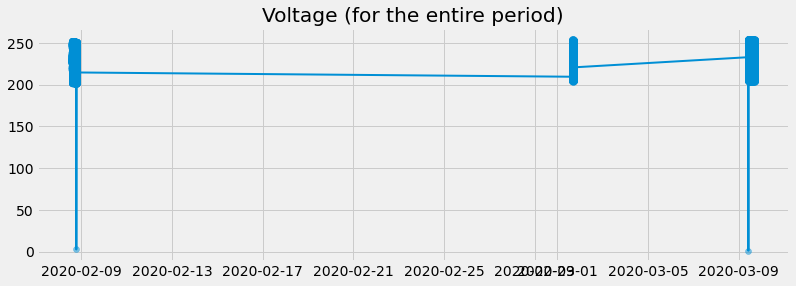

In [20]:
alldata = pd.concat(dfs)
alldata = alldata.sort_index()

fast_plot(alldata['Voltage'], title='Voltage (for the entire period)')

Due to the large intervals between experiments, it is difficult to see something valuable on such charts, you can build charts for individual days

In [21]:
# Number of experiments per day
display(summary_table['start_time'].dt.date.value_counts().sort_index())
alldata = pd.concat(dfs)
alldata = alldata.sort_index()

2020-02-08    11
2020-03-01     4
2020-03-09    20
Name: start_time, dtype: int64

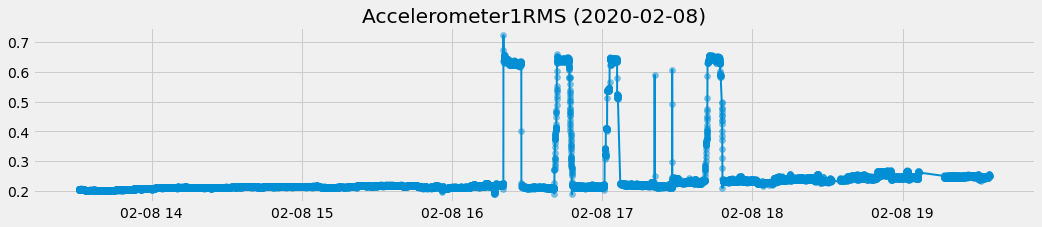

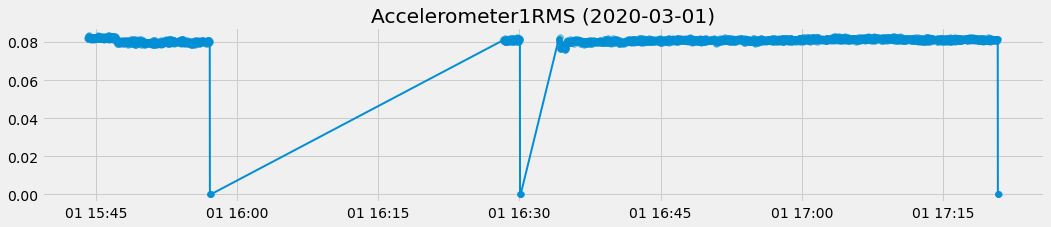

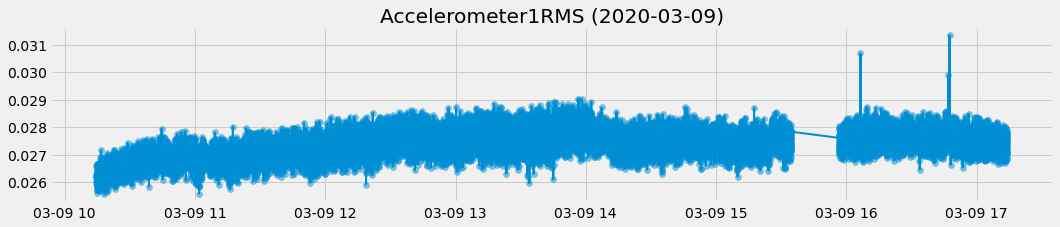

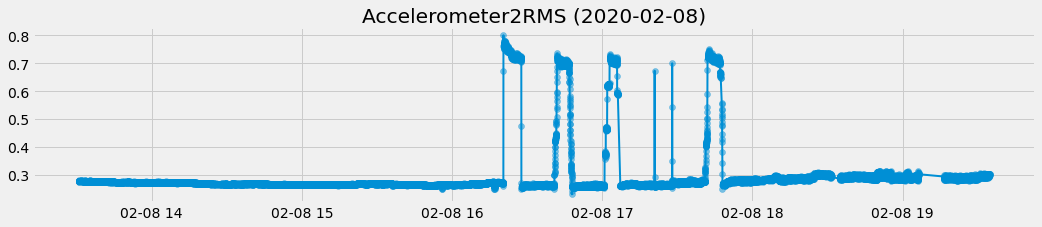

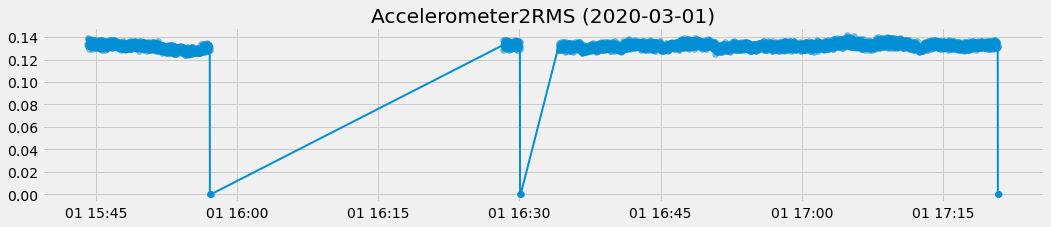

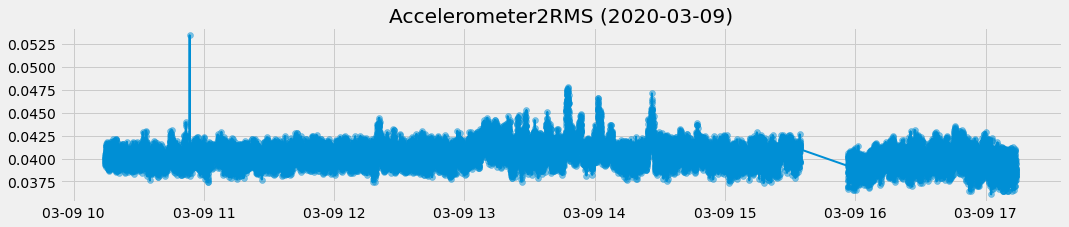

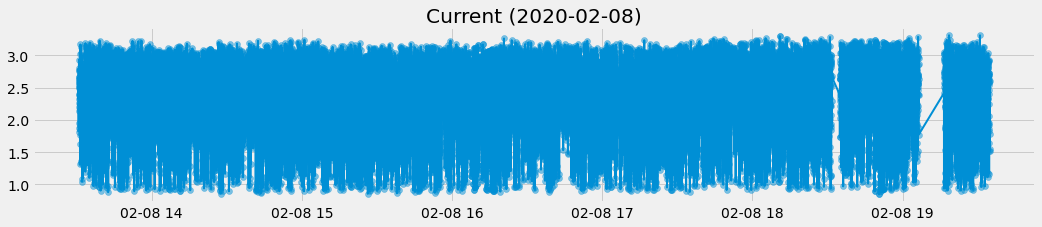

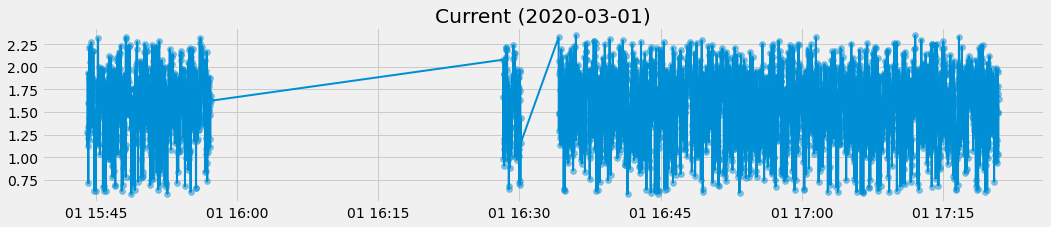

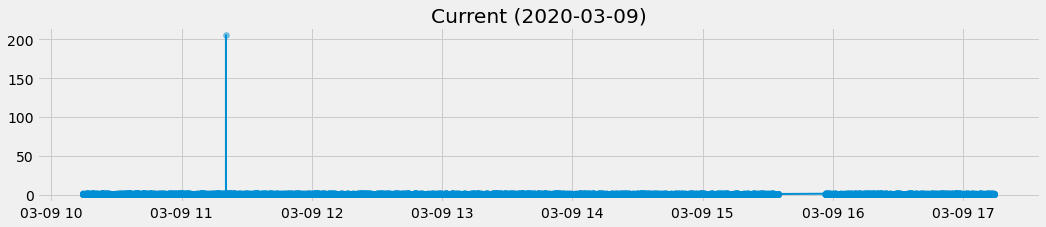

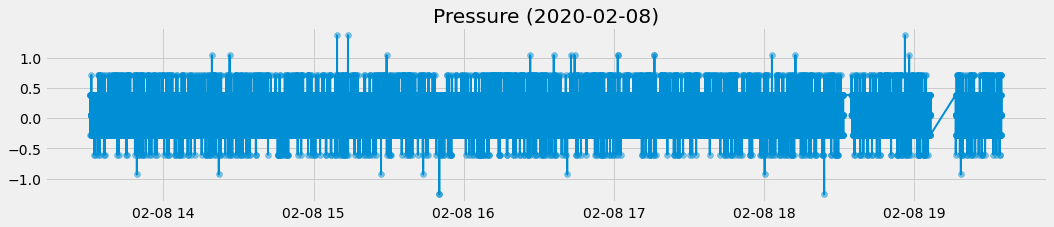

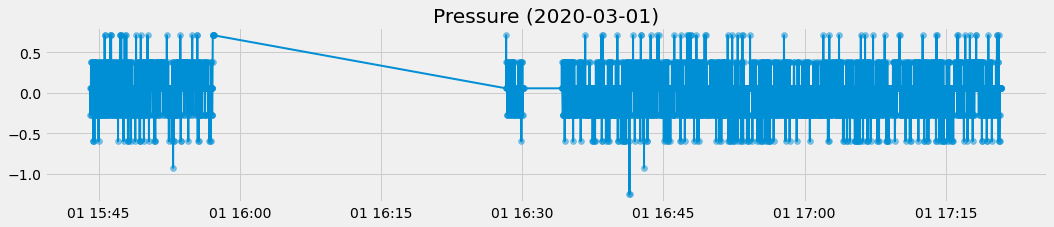

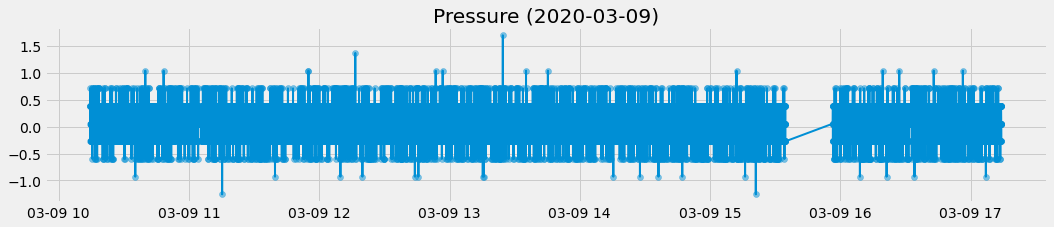

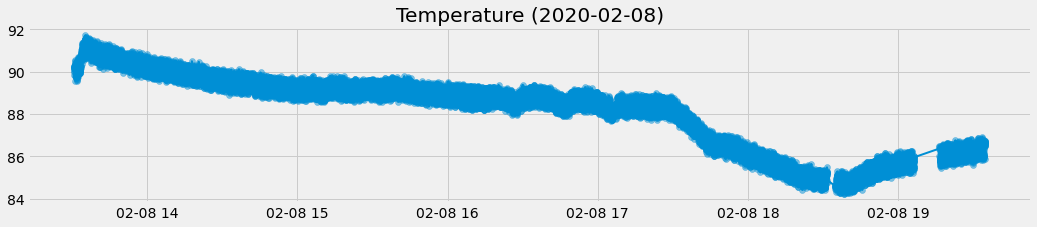

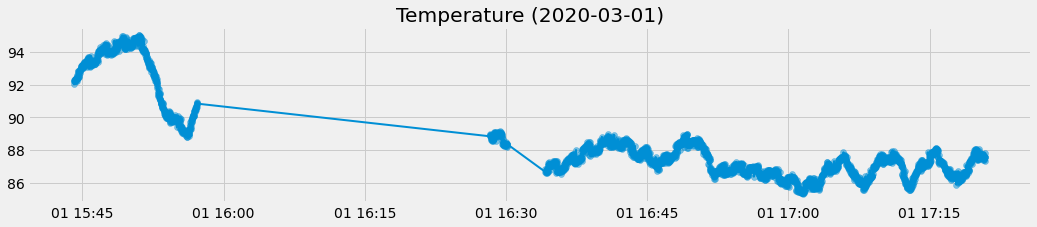

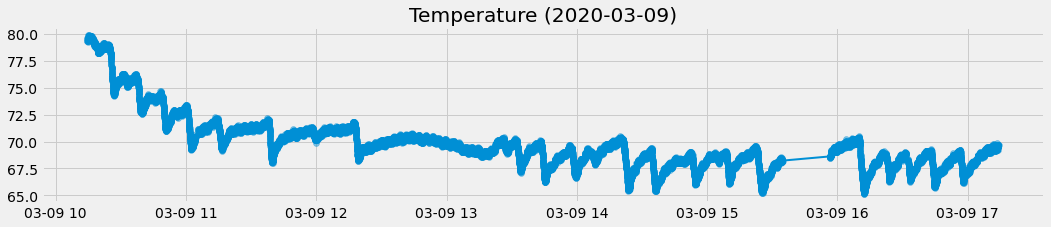

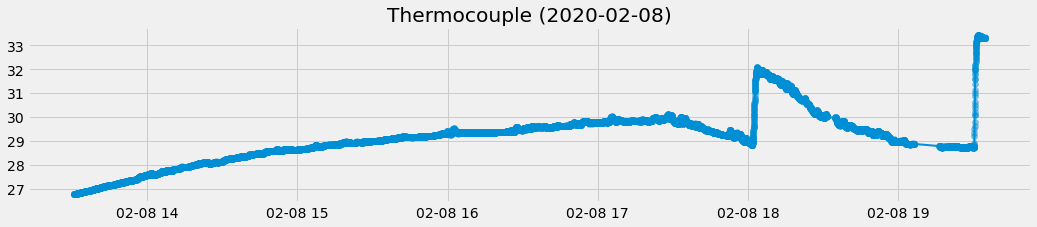

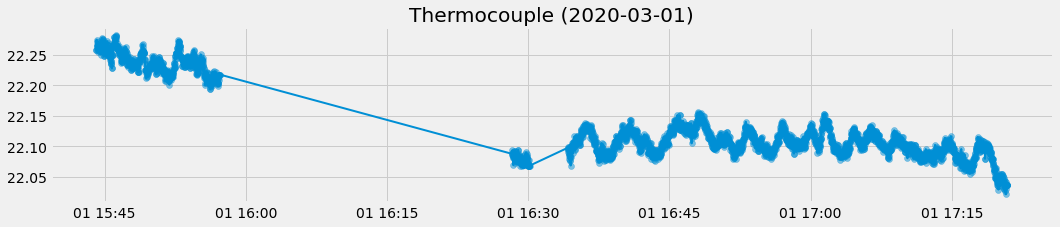

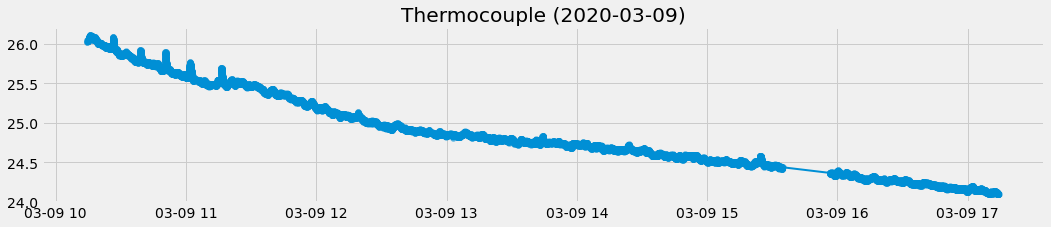

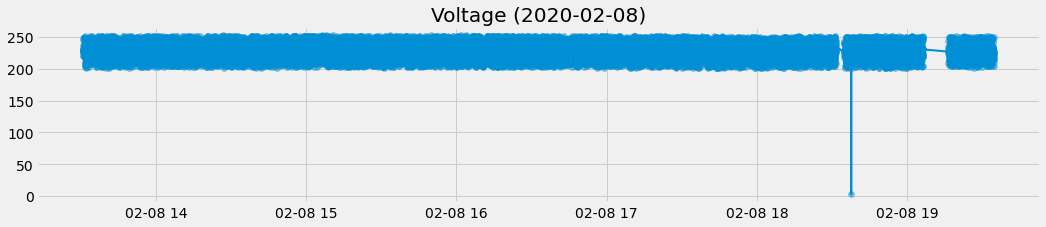

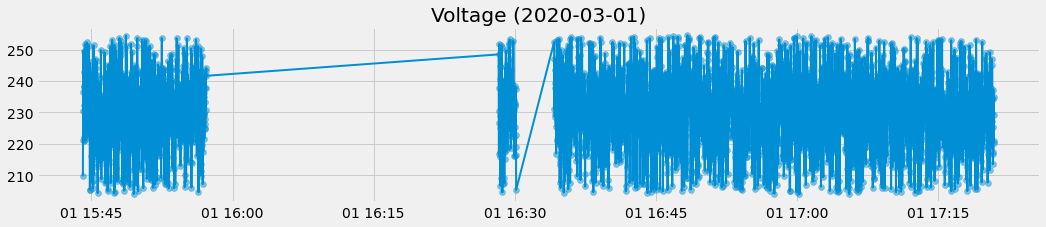

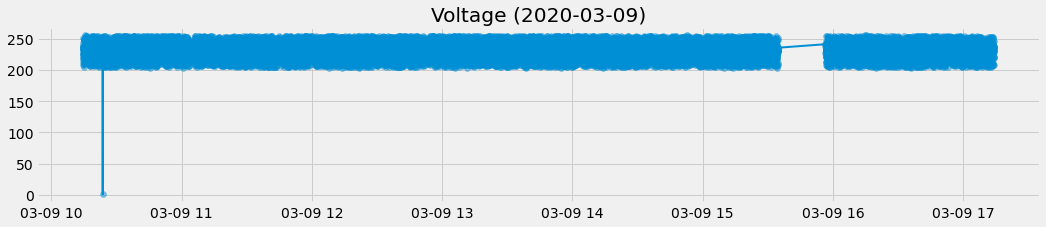

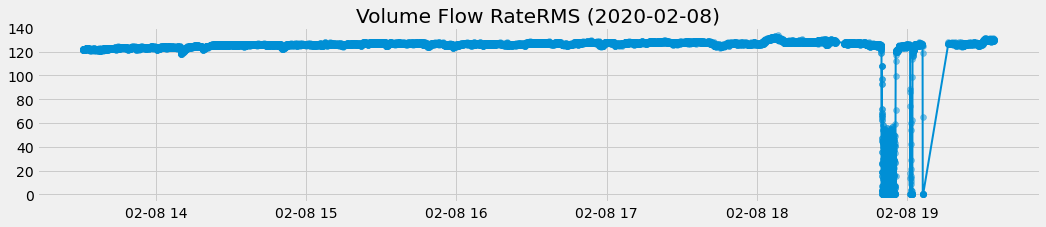

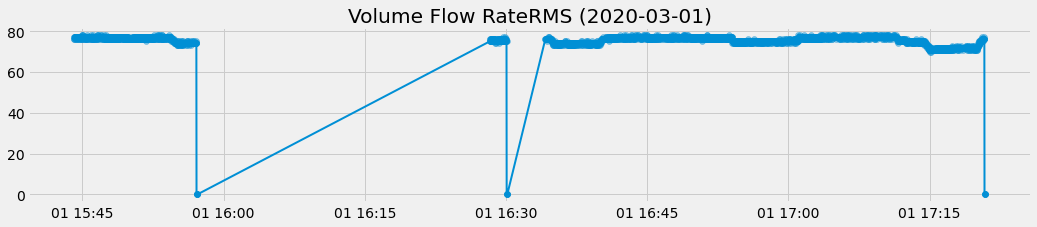

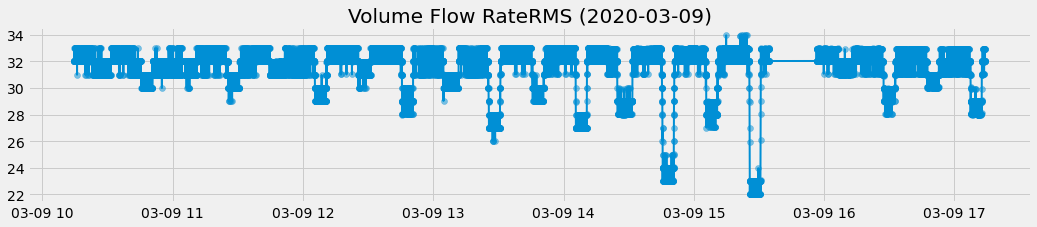

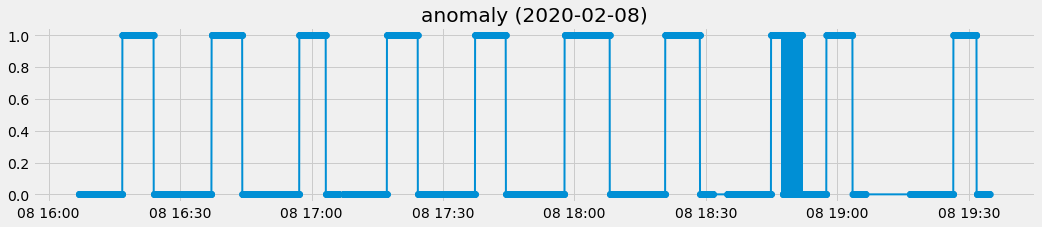

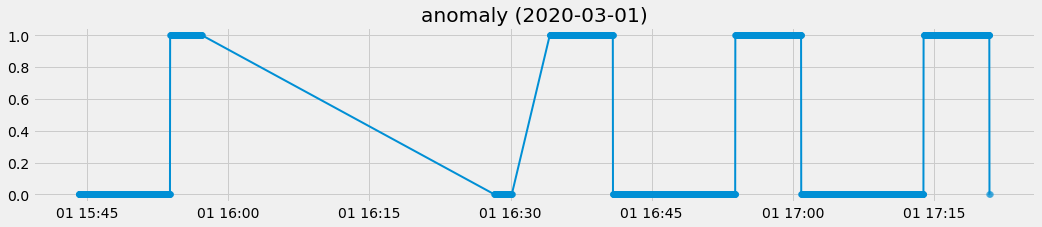

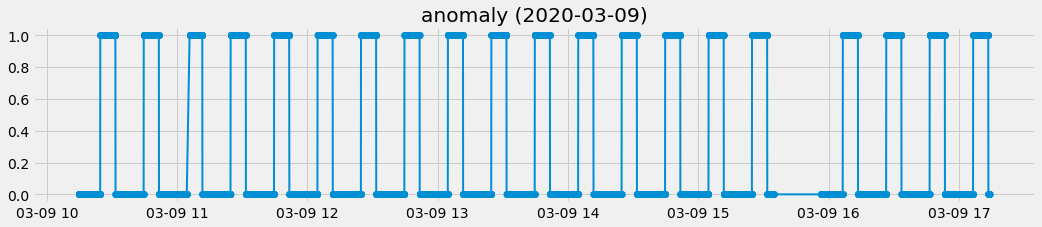

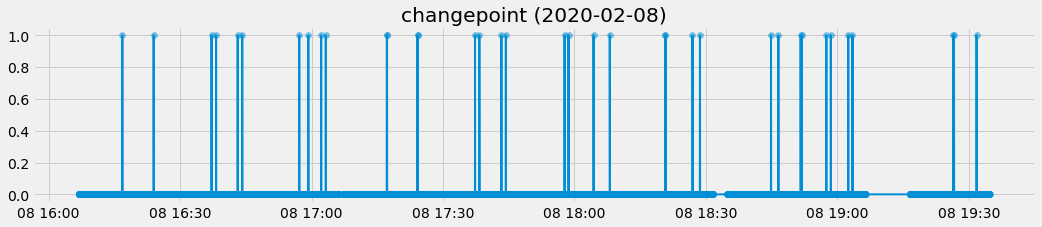

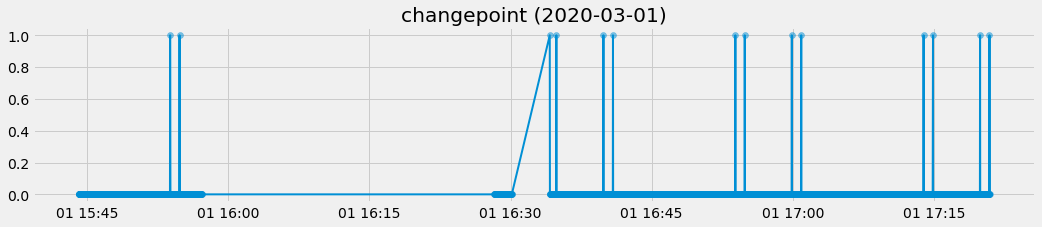

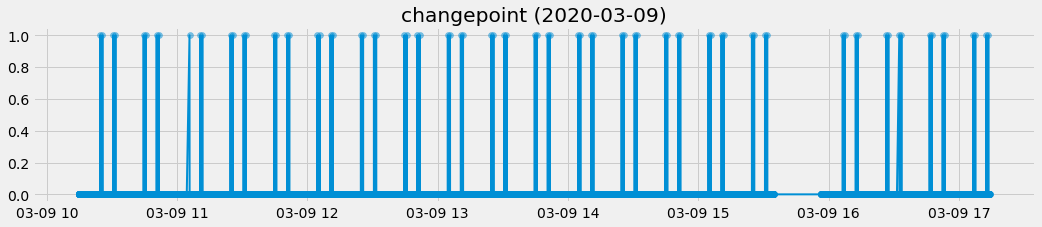

In [22]:
for column in alldata.columns:
    fast_plot(alldata[column]['2020-02-08'], title=column + ' (2020-02-08)', figsize=(16, 3))
    plt.show()
    fast_plot(alldata[column]['2020-03-01'], title=column + ' (2020-03-01)', figsize=(16, 3))
    plt.show()
    fast_plot(alldata[column]['2020-03-09'], title=column + ' (2020-03-09)', figsize=(16, 3))
    plt.show()
    print('\n\n')

The graphs show the following:
* Indications of vibration accelerations for February 8 have clear signs of anomalous behavior
* Consumption readings for February 8 show clear signs of anomalous behavior
* Thermocouple readings for February 8 show clear signs of anomalous behavior
* Hull temperature readings for March 9 are very different from other days

__Add to filtering:__
* Vibration acceleration > 0
* Consumption > 0
* Current < 100
* Voltage > 100

In [23]:
def filter_data(data):
    mask = ((data['Accelerometer1RMS'] > 0) &
            (data['Accelerometer2RMS'] > 0) & 
            (data['Volume Flow RateRMS'] > 0) & 
            (data['Current'] < 100) & 
            (data['Voltage'] > 100)
           )
    return data[mask]

In [24]:
for i in range(len(dfs)):
    dfs[i] = filter_data(dfs[i])
    
for i in range(len(valve1_data)):
    valve1_data[i] = filter_data(valve1_data[i])
    
for i in range(len(valve2_data)):
    valve2_data[i] = filter_data(valve2_data[i])
    
for i in range(len(other_data)):
    other_data[i] = filter_data(other_data[i])
    
alldata = filter_data(alldata)

> __TODO:__
> * Add filtering by current, voltage, consumption, and vibration accelerations to data preprocessing

<a id="2.2.4.4"></a>
#### 2.2.4.4 Plots with anomalies
Let's see how signal smoothing can reduce noise, for this we will build signal graphs and their smoothed values for 10 seconds

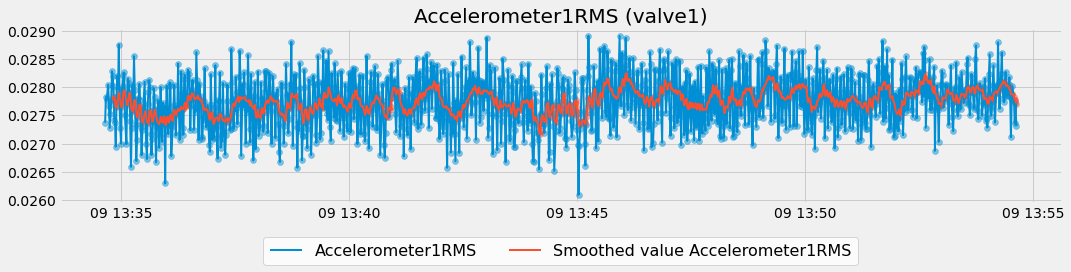

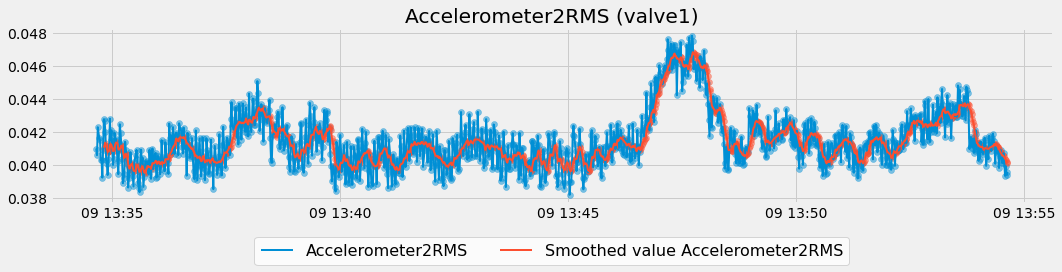

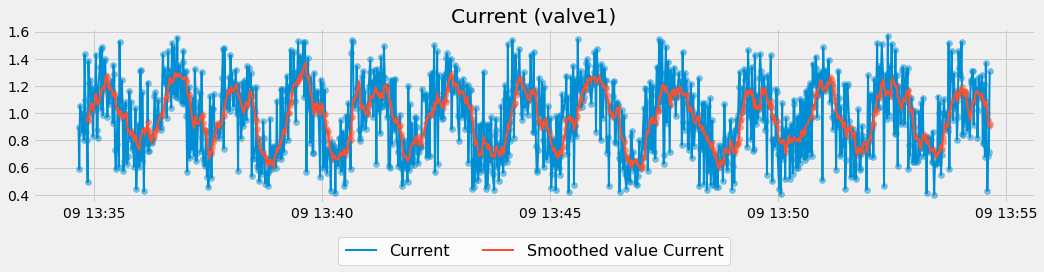

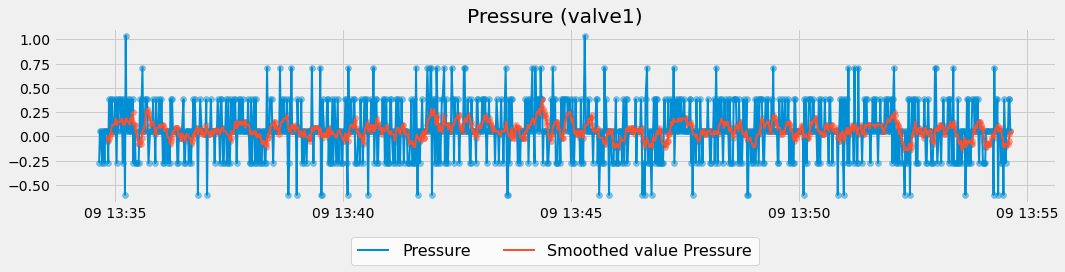

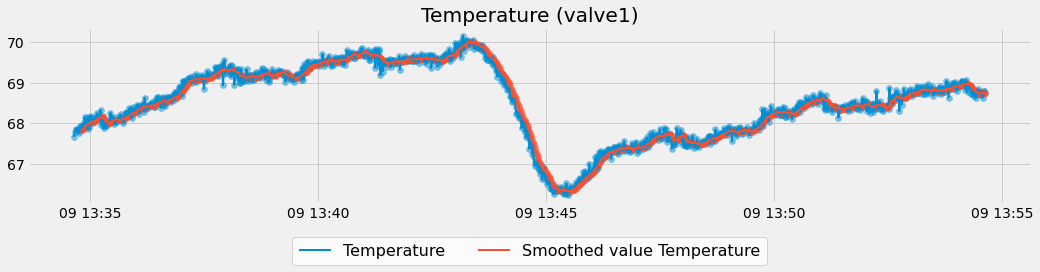

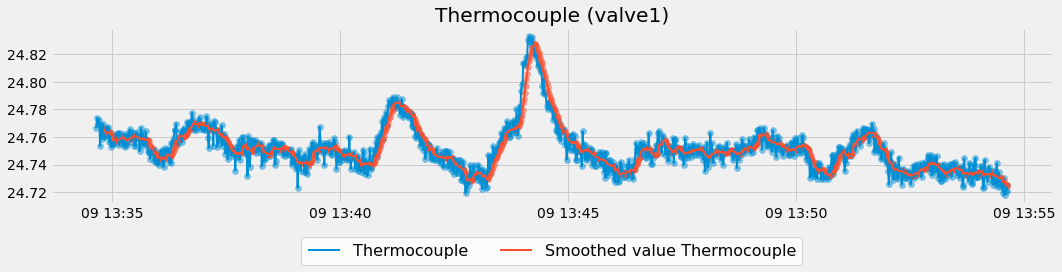

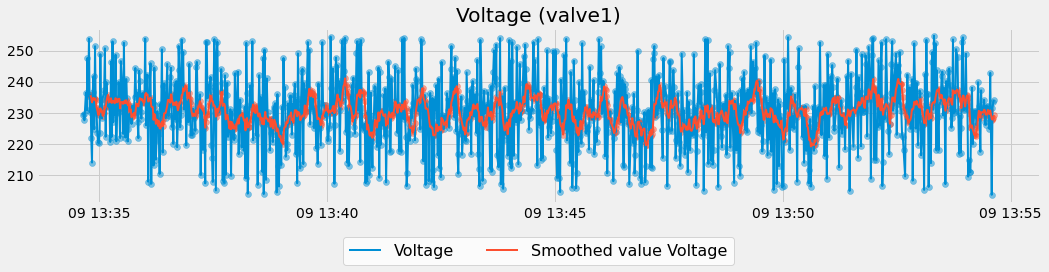

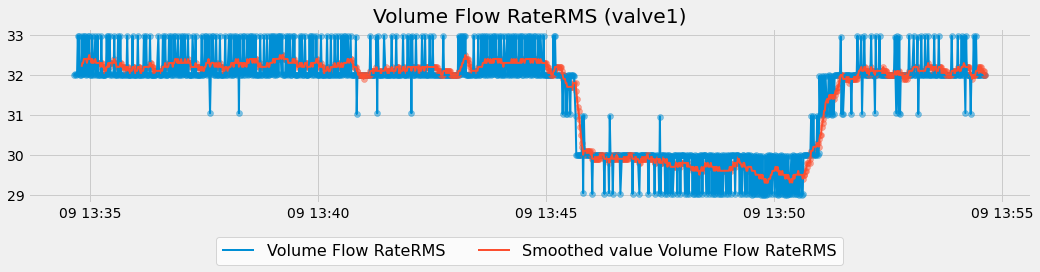

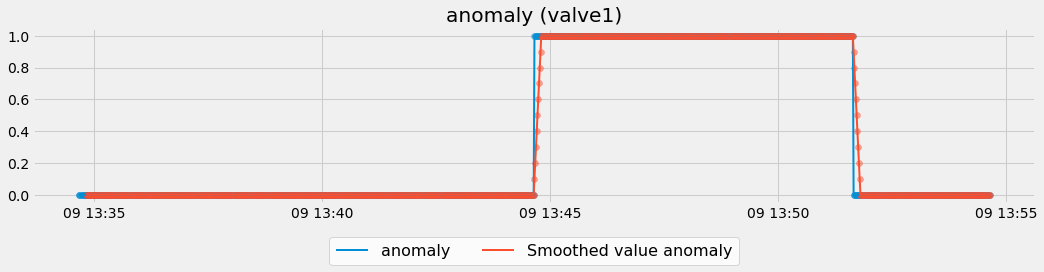

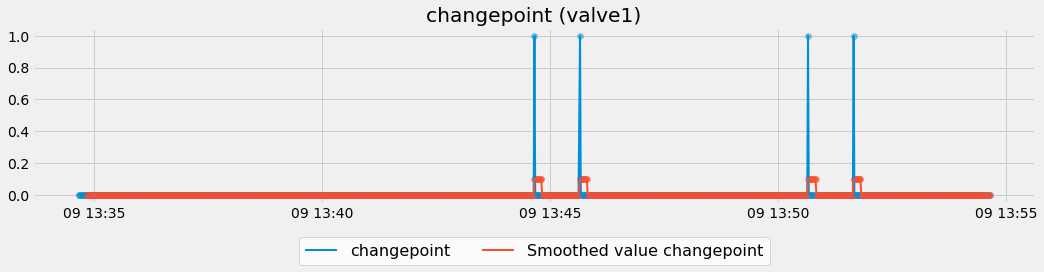

In [25]:
for column in valve1_data[2].columns:
    fast_plot(valve1_data[2][column], title=column + ' (valve1)', figsize=(16, 3), label=column)
    fast_plot(valve1_data[2][column], rolling=10, new_figure=False, label=f'Smoothed value {column}')
    fast_legend()

> __TODO:__
> * According to many parameters, there is noise in the signal, it is necessary to choose methods to combat noise (filtering, smoothing ...)

<a id="2.2.5"></a>
### 2.2.5 Measurement resolution
To estimate the discreteness, we calculate the time difference between adjacent rows for the data anomaly_free_data and other_data

In [26]:
display(Markdown('__Discreteness in the dataset without anomalies:__'))
display(anomaly_free_data.index.to_series().diff().value_counts())

display(Markdown('<br>__Discreteness in the dataset "Other anomalies" experiment №0:__'))
display(other_data[0].index.to_series().diff().value_counts())

__Discreteness in the dataset without anomalies:__

0 days 00:00:01    8840
0 days 00:00:02     560
Name: datetime, dtype: int64

<br>__Discreteness in the dataset "Other anomalies" experiment №0:__

0 days 00:00:01    627
0 days 00:00:02     31
0 days 00:04:07      1
Name: datetime, dtype: int64

To estimate the periods of no data recording, we calculate for each dataset the maximum time difference between adjacent rows

In [27]:
summary_table['Max_Missing_Period'] = np.NaN
for i in range(len(dfs)):
    summary_table.loc[i, 'Max_Missing_Period'] = str(dfs[i].index.to_series().diff().value_counts().index.to_series().max())
    
display(summary_table)

anomaly_type experiment  \
0   anomaly_free          0   
1         valve1          0   
2         valve1          1   
3         valve1          2   
4         valve1          3   
5         valve1          4   
6         valve1          5   
7         valve1          6   
8         valve1          7   
9         valve1          8   
10        valve1          9   
11        valve1         10   
12        valve1         11   
13        valve1         12   
14        valve1         13   
15        valve1         14   
16        valve1         15   
17        valve2          0   
18        valve2          1   
19        valve2          2   
20        valve2          3   
21         other          0   
22         other          1   
23         other          2   
24         other          3   
25         other          4   
26         other          5   
27         other          6   
28         other          7   
29         other          8   
30         other          9   
31         other         10   
32         other         11   
33         other         12   
34         other         13   

                                          description        duration  rows  \
0                                         Normal mode 0 days 02:46:00  9401   
1            Closing the valve downstream of the pump 0 days 00:19:59  1148   
2            Closing the valve downstream of the pump 0 days 00:20:00  1145   
3            Closing the valve downstream of the pump 0 days 00:19:59  1146   
4            Closing the valve downstream of the pump 0 days 00:20:00  1141   
5            Closing the valve downstream of the pump 0 days 00:20:00  1140   
6            Closing the valve downstream of the pump 0 days 00:19:59  1140   
7            Closing the valve downstream of the pump 0 days 00:19:59  1139   
8            Closing the valve downstream of the pump 0 days 00:20:00  1150   
9            Closing the valve downstream of the pump 0 days 00:19:59  1075   
10           Closing the valve downstream of the pump 0 days 00:20:01  1149   
11           Closing the valve downstream of the pump 0 days 00:19:59  1095   
12           Closing the valve downstream of the pump 0 days 00:19:59  1154   
13           Closing the valve downstream of the pump 0 days 00:19:59  1154   
14           Closing the valve downstream of the pump 0 days 00:20:00  1094   
15           Closing the valve downstream of the pump 0 days 00:19:58  1144   
16           Closing the valve downstream of the pump 0 days 00:20:00  1148   
17    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1125   
18    Closing the valve at the inlet flow to the pump 0 days 00:20:00  1063   
19    Closing the valve at the inlet flow to the pump 0 days 00:19:59  1129   
20    Closing the valve at the inlet flow to the pump 0 days 00:17:38   995   
21                                     No description 0 days 00:15:36   665   
22                                     No description 0 days 00:19:58  1137   
23                  Sharp behavior of rotor unbalance 0 days 00:17:00   968   
24                 Linear behavior of rotor unbalance 0 days 00:20:08  1153   
25                   Step behavior of rotor unbalance 0 days 00:20:00  1147   
26  Behavior of the Dirac delta function of rotor ... 0 days 00:19:02  1091   
27               Exponential rotor unbalance behavior 0 days 00:20:02  1147   
28  Slow increase in the amount of water in the ci... 0 days 00:20:00  1145   
29  Sudden increase in the amount of water in the ... 0 days 00:23:18  1326   
30         Draining water from the tank to cavitation 0 days 00:20:54  1191   
31  Feeding a two-phase flow to the pump inlet (ca... 0 days 00:20:03  1141   
32                  Elevated temperature water supply 0 days 00:18:57  1079   
33                                     No description 0 days 00:18:17  1044   
34                                     No description 0 days 00:13:07   751   

   anomaly_percent changepoints Nas       

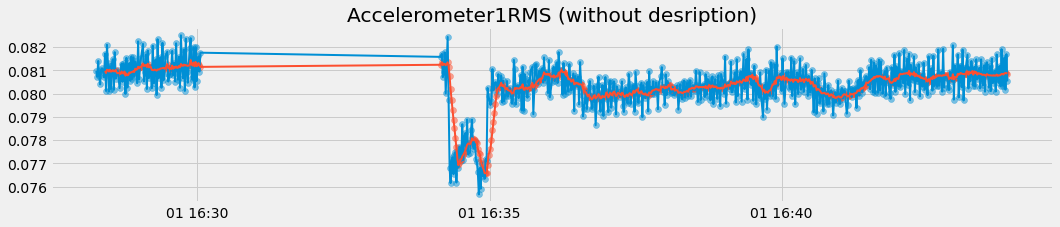

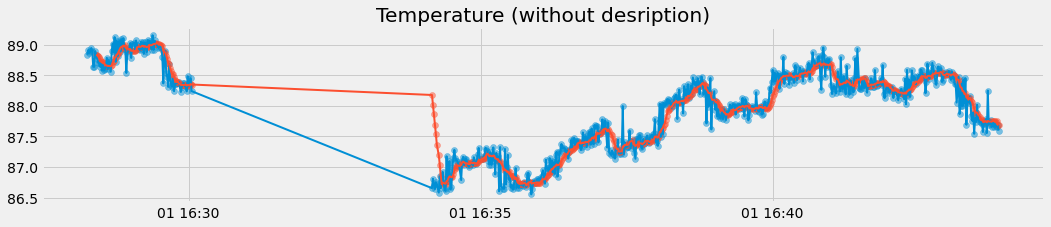

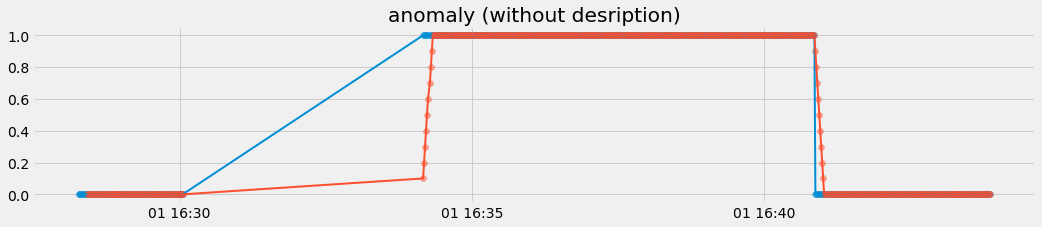

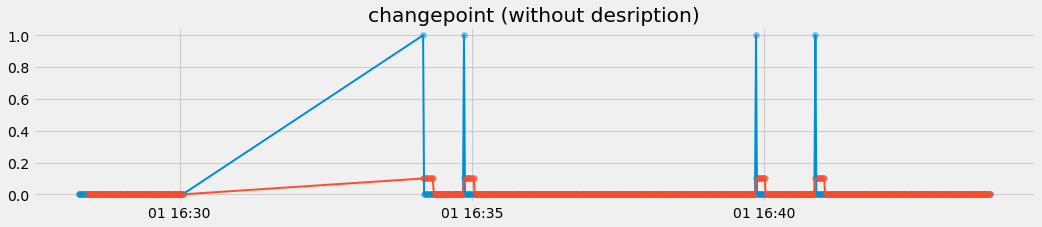

In [28]:
columns = ['Accelerometer1RMS', 'Temperature', 'anomaly', 'changepoint']
for column in columns:
    fast_plot(other_data[0][column], title=column + ' (without desription)', figsize=(16, 3))
    fast_plot(other_data[0][column], rolling=10, new_figure=False)

There are experiments in which, right before the start of the anomaly, there are large gaps in the data.
> __Hypothesis:__
> * It is worth removing such experiments from the training and test sets

<a id="2.2.6"></a>
### 2.2.6 Pairwise Correlations
Pairwise correlation information can often be used to search for relationships between features.

__Data without anomalies:__

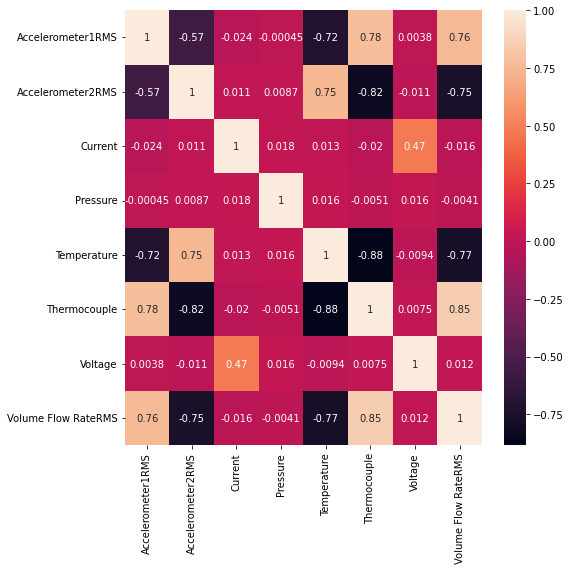

In [29]:
plt.figure(figsize=(8, 8))
display(Markdown('__Data without anomalies:__'))
sns.heatmap(anomaly_free_data_corrected.corr(), annot = True, fmt='.2g');

__Data in dataset "valve1" experiment #2:__

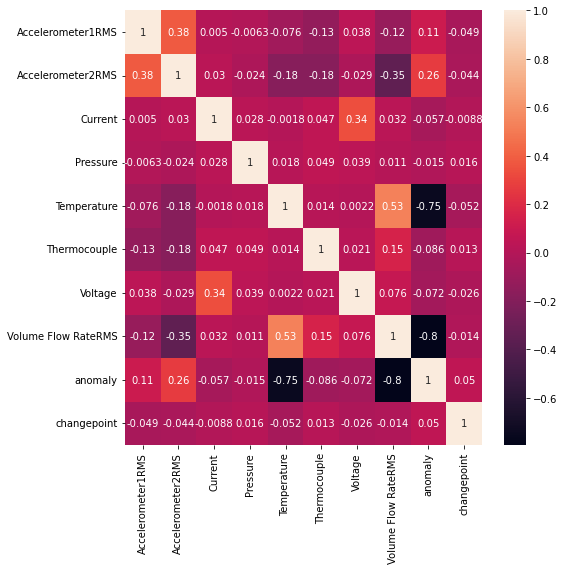

In [30]:
plt.figure(figsize=(8, 8))
display(Markdown('__Data in dataset "valve1" experiment #2:__'))
sns.heatmap(valve1_data[2].corr(), annot = True, fmt='.2g');

__Data for the entire period:__

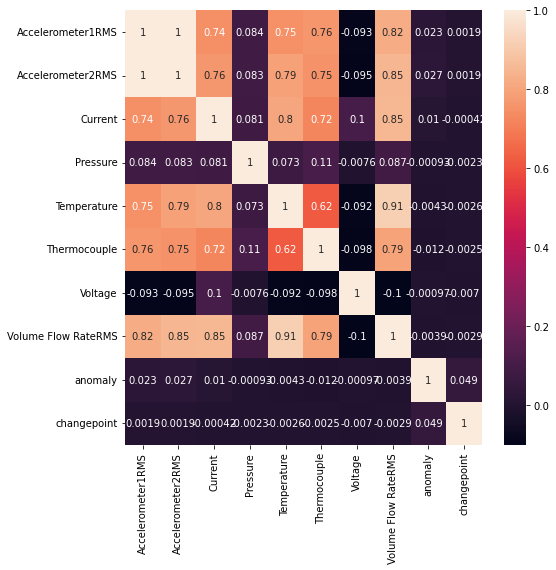

In [31]:
plt.figure(figsize=(8, 8))
display(Markdown('__Data for the entire period:__'))
sns.heatmap(alldata.corr(), annot = True, fmt='.2g');

Observations:
* High negative correlation between flow rate and target variable for dataset "valve1" experiment #2
* The correlation of signals in individual datasets is very different from each other and from the correlation for the entire period


<a id="2.2.7"></a>
### 2.2.7 Pairplot
To search for relationships between features, you can also use the pairplot function from the seaborn library, which combines all possible scatterplots and histograms

ValueError: cannot reindex from a duplicate axis

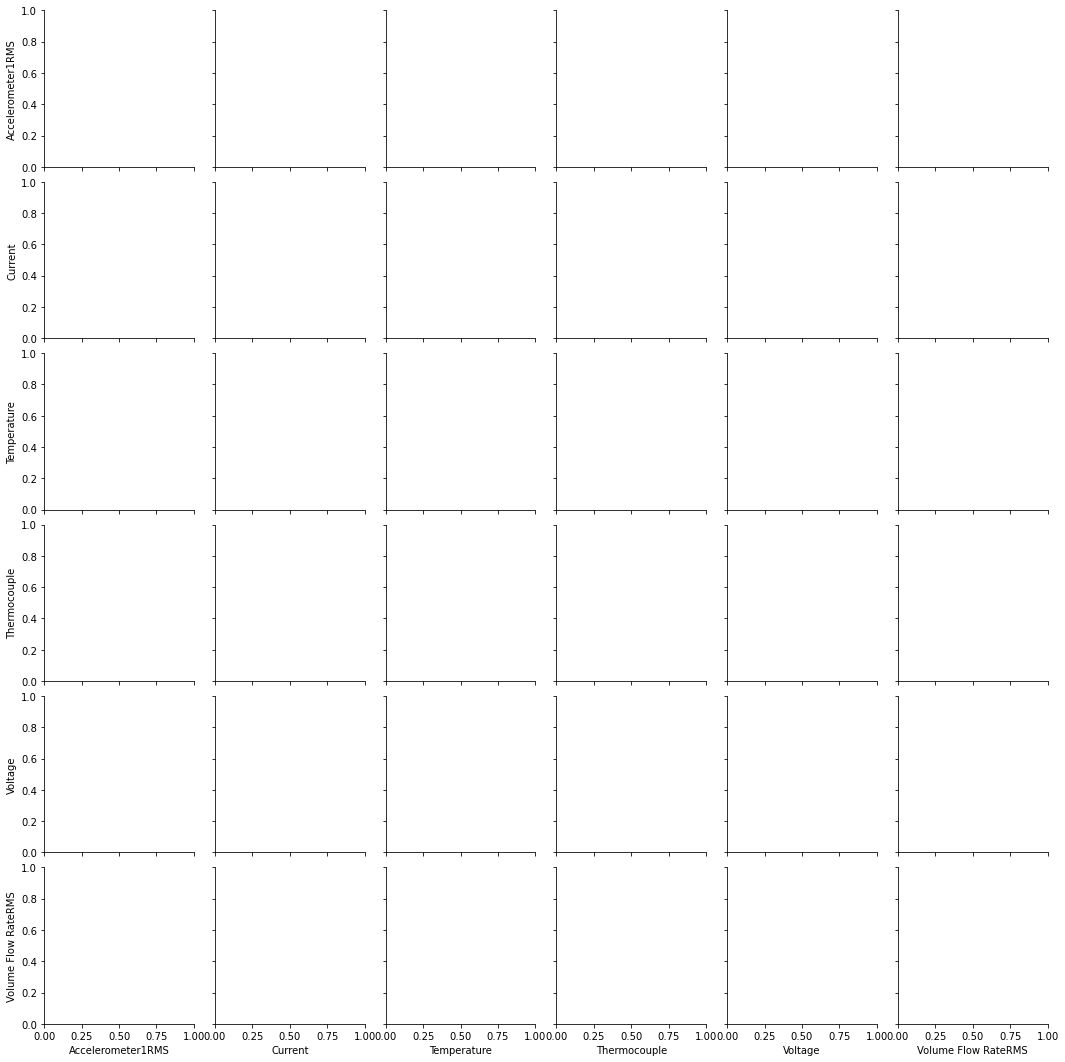

In [32]:
%%time
features = ['Accelerometer1RMS', 'Current', 'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS']
sns.pairplot(alldata[features]);
plt.show()

<a id="2.2.8"></a>
### 2.2.8 Determination of the operation modes: transfer mode, work mode, stop mode
* Stages of entering the mode, work and stops were not found in the data

Let's look at the statistics within individual days

In [47]:
period1 = alldata['2020-02-08'].describe().T[['mean', 'std']]
period2 = alldata['2020-03-01'].describe().T[['mean', 'std']]
period3 = alldata['2020-03-09'].describe().T[['mean', 'std']]
period1.columns = ['mean 2020-02-08', 'std 2020-02-08']
period2.columns = ['mean 2020-03-01', 'std 2020-03-01']
period3.columns = ['mean 2020-03-09', 'std 2020-03-09']
periods = pd.concat([period1, period2, period3], axis=1)
columns = ['mean 2020-02-08', 'mean 2020-03-01', 'mean 2020-03-09',
           'std 2020-02-08', 'std 2020-03-01', 'std 2020-03-09']
display(Markdown('__Статистики различных режимов работы:__'))
display(periods[columns])

<ipython-input-47-258482c5d725>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  period1 = alldata['2020-02-08'].describe().T[['mean', 'std']]
<ipython-input-47-258482c5d725>:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  period2 = alldata['2020-03-01'].describe().T[['mean', 'std']]
<ipython-input-47-258482c5d725>:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  period3 = alldata['2020-03-09'].describe().T[['mean', 'std']]


__Статистики различных режимов работы:__

mean 2020-02-08  mean 2020-03-01  mean 2020-03-09  \
Accelerometer1RMS           0.248748         0.080948         0.027386   
Accelerometer2RMS           0.301708         0.132172         0.040396   
Current                     2.413636         1.573303         0.973531   
Pressure                    0.110509         0.019439         0.062095   
Temperature                88.132343        88.339118        69.837766   
Thermocouple               29.155727        22.131326        24.877112   
Voltage                   228.254745       230.122095       230.709989   
Volume Flow RateRMS       123.889995        75.553927        31.336367   
anomaly                     0.353579         0.389444         0.348256   
changepoint                 0.003290         0.003709         0.003515   

                     std 2020-02-08  std 2020-03-01  std 2020-03-09  
Accelerometer1RMS          0.099608        0.000959        0.000509  
Accelerometer2RMS          0.105805        0.002812        0.001216  
Current                    0.487203        0.385389        0.272899  
Pressure                   0.254546        0.265937        0.259694  
Temperature                1.733624        2.486698        2.509560  
Thermocouple               1.055654        0.058921        0.510227  
Voltage                   10.947722       10.946561       10.811537  
Volume Flow RateRMS       15.347089        1.696994        1.866238  
anomaly                    0.478102        0.487694        0.476428  
changepoint                0.057270        0.060797        0.059189

Observations:
* Each day in the sample corresponds to its own mode of operation, which is best seen by the average values and standard deviations of flow and current

> __Questions:__
> * How many operating modes can there be?
> * What parameters determine the operating modes?

> __Hypotheses:__
> * Since the parameters for different modes of operation vary greatly, it is necessary to add the mode of operation as a feature to the selections when training and inferencing models

<a id="2.3"></a>
## 2.3 Feature Analysis
This section provides a more detailed analysis of each signal.

<a id="2.3.1"></a>
### 2.3.1 Flow rate

First of all, for the analysis of parameters, it is useful to look at the distribution of values using a histogram

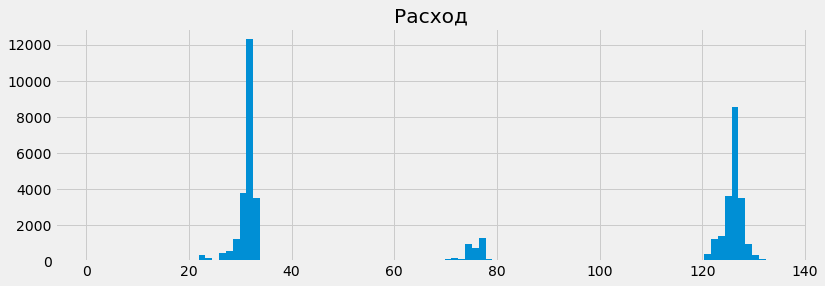

In [48]:
fast_hist(alldata['Volume Flow RateRMS'], title='Расход', n=100)

By distribution, 3 main modes can be distinguished.

We will build consumption trends for each individual day, while the values in abnormal operating modes will be highlighted in red

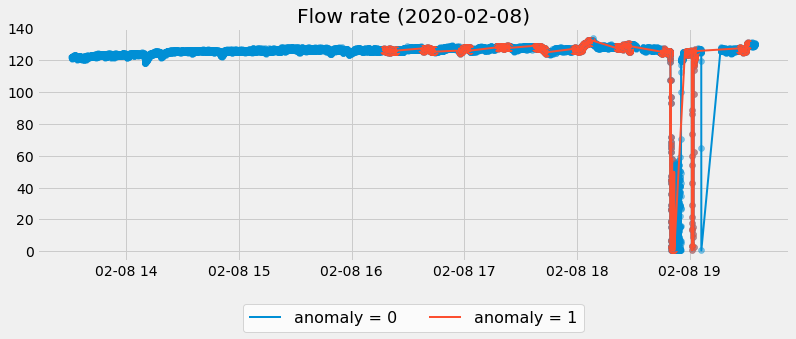

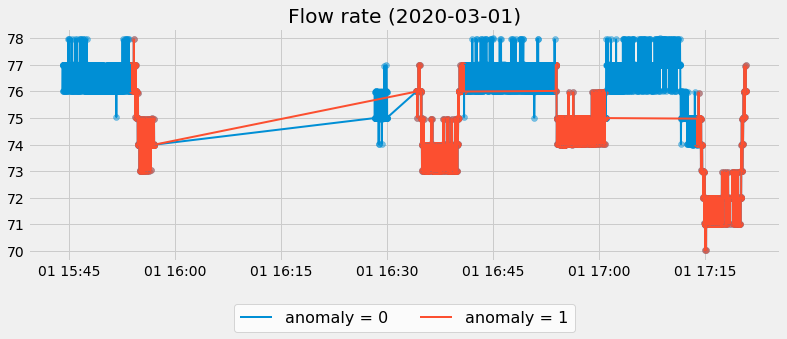

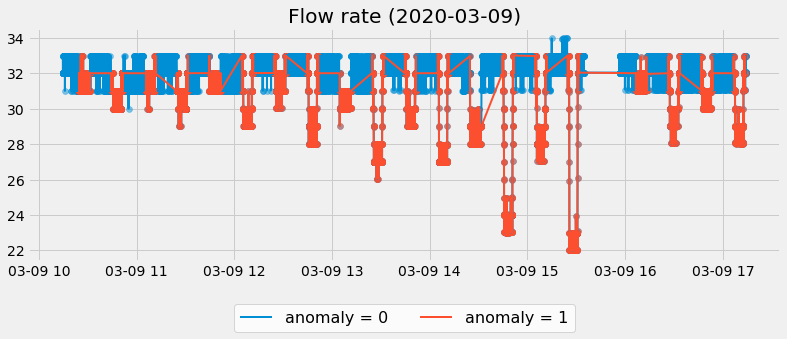

In [49]:
fast_plot(alldata['Volume Flow RateRMS']['2020-02-08'], title='Flow rate (2020-02-08)', label='anomaly = 0')
mask = alldata['anomaly']['2020-02-08'] == 1
fast_plot(alldata['Volume Flow RateRMS']['2020-02-08'][mask], new_figure=False, label='anomaly = 1')
fast_legend()

fast_plot(alldata['Volume Flow RateRMS']['2020-03-01'], title='Flow rate (2020-03-01)', label='anomaly = 0')
mask = alldata['anomaly']['2020-03-01'] == 1
fast_plot(alldata['Volume Flow RateRMS']['2020-03-01'][mask], new_figure=False, label='anomaly = 1')
fast_legend()

fast_plot(alldata['Volume Flow RateRMS']['2020-03-09'], title='Flow rate (2020-03-09)', label='anomaly = 0')
mask = alldata['anomaly']['2020-03-09'] == 1
fast_plot(alldata['Volume Flow RateRMS']['2020-03-09'][mask], new_figure=False, label='anomaly = 1')
fast_legend();

It can be noted that during drawdowns in consumption, anomalous modes are observed

Consider the 15 most common consumption values for March 9

In [50]:
alldata['Volume Flow RateRMS']['2020-03-09'].value_counts().head(15)

32.0000    8326
31.0000     825
29.0000     665
33.0000     536
30.0000     519
27.0000     339
28.0000     146
24.0000     125
23.0000     101
30.0002      61
30.9998      60
32.0126      50
32.0134      50
32.9877      50
32.9875      49
Name: Volume Flow RateRMS, dtype: int64

> __Hypotheses:__
> * A decrease in flow (within one mode of operation) often indicates the onset of an anomaly

> __Questions:__
> * How is the flow regulated? (valve closing + current)?
> * When are flow signals rounded off?

<a id="2.3.2"></a>
### 2.3.2 Vibrations
Vibration accelerations can be considered as a pair for both measurement points

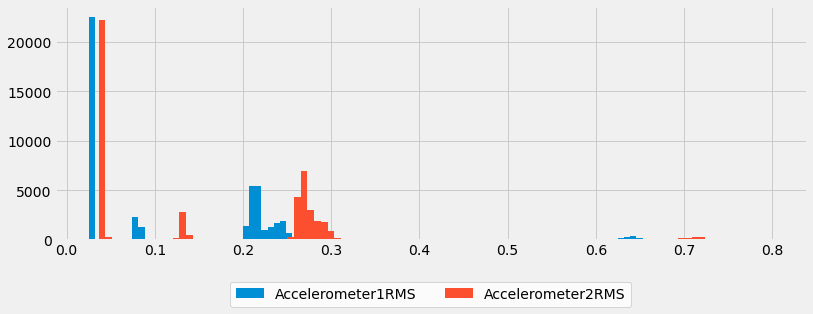

In [51]:
fast_hist(alldata['Accelerometer1RMS'], title='Виброускорения', n=100, label='Accelerometer1RMS')
fast_hist(alldata['Accelerometer2RMS'], new_figure=False, n=100, label='Accelerometer2RMS')
fast_legend(fontsize=14);

Observations:
* The magnitude of vibration acceleration at the second point is on average higher than at the first.

Let's build a scatter diagram for two points of vibration acceleration

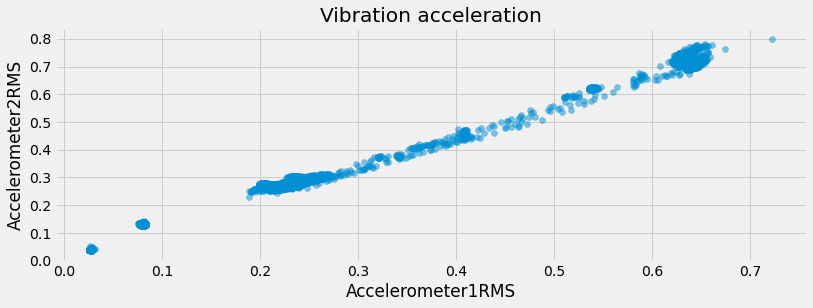

In [52]:
fast_scatter(alldata['Accelerometer1RMS'], alldata['Accelerometer2RMS'], title='Vibration acceleration')
plt.xlabel('Accelerometer1RMS')
plt.ylabel('Accelerometer2RMS');

In [53]:
# Correlation of vibration acceleration values
alldata[['Accelerometer1RMS', 'Accelerometer2RMS']].corr()

Accelerometer1RMS  Accelerometer2RMS
Accelerometer1RMS           1.000000           0.996435
Accelerometer2RMS           0.996435           1.000000

> __Hypothesis:__
> * Since the correlation of vibration acceleration values is very close to 1, the values are close and measure the same parameters, it would be a good option to choose 1 of the two signs, and replace the second one with the difference between these two parameters

Let's plot the trends of vibration accelerations at point 1 for each individual day, while the values in anomalous operating modes will be highlighted in red

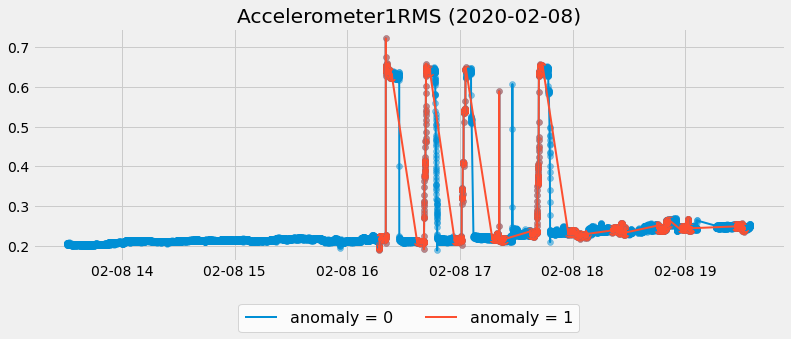

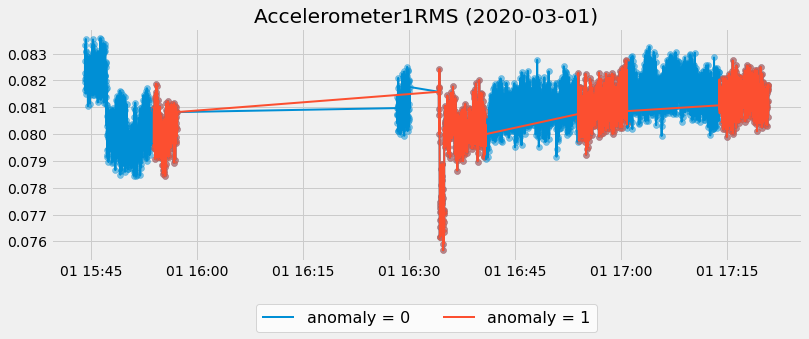

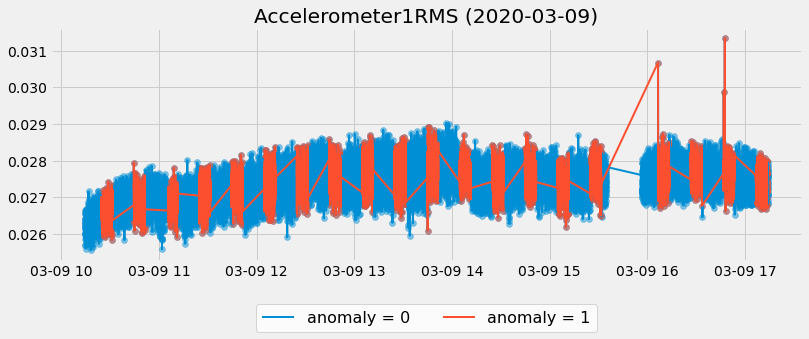

In [54]:
mask = alldata['anomaly']['2020-02-08'] == 1
fast_plot((alldata['Accelerometer1RMS'])['2020-02-08'], title='Accelerometer1RMS (2020-02-08)', label='anomaly = 0')
fast_plot((alldata['Accelerometer1RMS'])['2020-02-08'][mask], new_figure=False, label='anomaly = 1')
fast_legend();

mask = alldata['anomaly']['2020-03-01'] == 1
fast_plot((alldata['Accelerometer1RMS'])['2020-03-01'], title='Accelerometer1RMS (2020-03-01)', label='anomaly = 0')
fast_plot((alldata['Accelerometer1RMS'])['2020-03-01'][mask], new_figure=False, label='anomaly = 1')
fast_legend();

mask = alldata['anomaly']['2020-03-09'] == 1
fast_plot((alldata['Accelerometer1RMS'])['2020-03-09'], title='Accelerometer1RMS (2020-03-09)', label='anomaly = 0')
fast_plot((alldata['Accelerometer1RMS'])['2020-03-09'][mask], new_figure=False, label='anomaly = 1')
fast_legend();

Let's build the same chart for the period from 2020-02-08 16:00 to 18:00

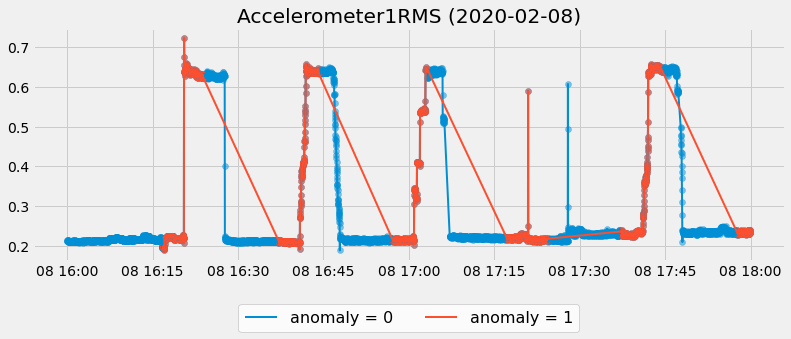

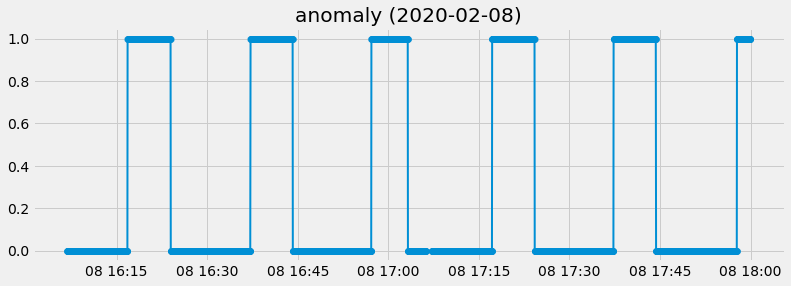

In [55]:
mask = alldata['anomaly']['2020-02-08 16' : '2020-02-08 17'] == 1
fast_plot((alldata['Accelerometer1RMS'])['2020-02-08 16' : '2020-02-08 17'], title='Accelerometer1RMS (2020-02-08)',
          label='anomaly = 0')
fast_plot((alldata['Accelerometer1RMS'])['2020-02-08 16' : '2020-02-08 17'][mask], new_figure=False, label='anomaly = 1')
fast_legend();

fast_plot((alldata['anomaly'])['2020-02-08 16' : '2020-02-08 17'], title='anomaly (2020-02-08)', label='anomaly = 0')

It can be noted that both normal and abnormal periods contain high vibration values.

In the summary table, let's see what experiments were carried out in the period from 16:00 to 18:00 2020-02-08

In [56]:
summary_table[(summary_table['start_time'] >= pd.to_datetime('2020-02-08 16:00')) & 
              (summary_table['start_time'] <= pd.to_datetime('2020-02-08 18:00'))]

anomaly_type experiment                                        description  \
24        other          3                 Linear behavior of rotor unbalance   
25        other          4                   Step behavior of rotor unbalance   
26        other          5  Behavior of the Dirac delta function of rotor ...   
27        other          6               Exponential rotor unbalance behavior   
28        other          7  Slow increase in the amount of water in the ci...   
29        other          8  Sudden increase in the amount of water in the ...   

          duration  rows anomaly_percent changepoints Nas          start_time  \
24 0 days 00:20:08  1153           35.56          2.0   0 2020-02-08 16:06:48   
25 0 days 00:20:00  1147           34.96          4.0   0 2020-02-08 16:27:09   
26 0 days 00:19:02  1091           31.71          4.0   0 2020-02-08 16:47:11   
27 0 days 00:20:02  1147           35.14          4.0   0 2020-02-08 17:07:11   
28 0 days 00:20:00  1145           35.11          4.0   0 2020-02-08 17:27:18   
29 0 days 00:23:18  1326           44.27          4.0   0 2020-02-08 17:47:44   

           finish_time  Value_Swap Max_Missing_Period  
24 2020-02-08 16:26:56           1    0 days 00:00:02  
25 2020-02-08 16:47:09           0    0 days 00:00:02  
26 2020-02-08 17:06:13           0    0 days 00:00:02  
27 2020-02-08 17:27:13           2    0 days 00:00:02  
28 2020-02-08 17:47:18           0    0 days 00:00:02  
29 2020-02-08 18:11:02           1    0 days 00:00:02

Consider the graphs of vibration accelerations and the target variable anomaly for the following experiments:
* #24 - Linear behavior of rotor unbalance
* #25 - Staggered rotor unbalance behavior
* #26 - Behavior of the Dirac Delta Function of Rotor Imbalance

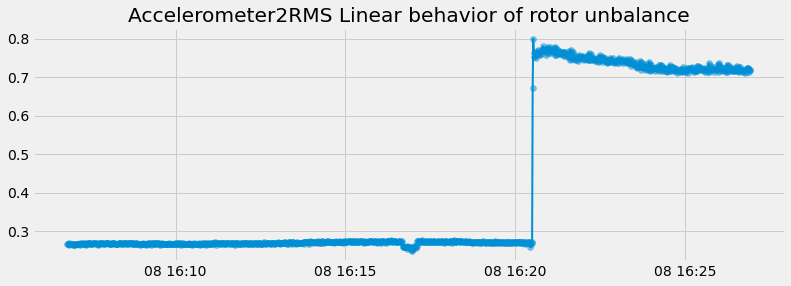

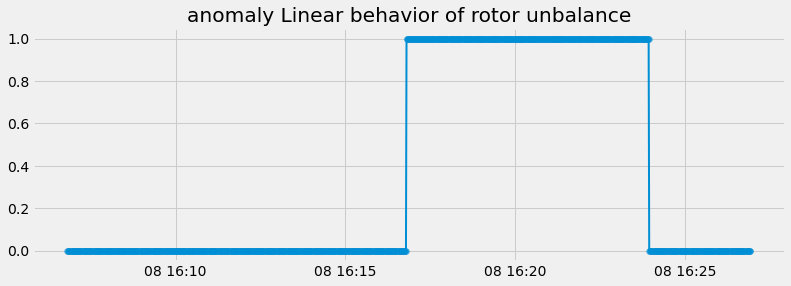

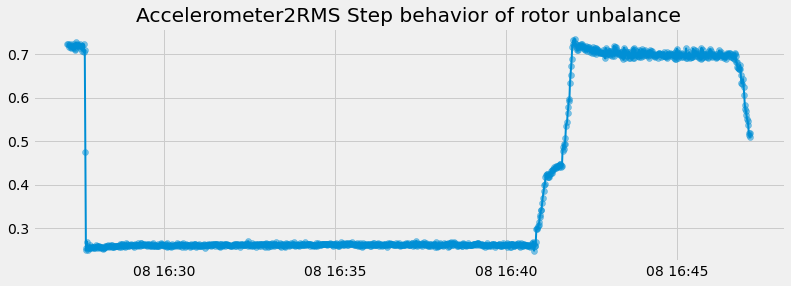

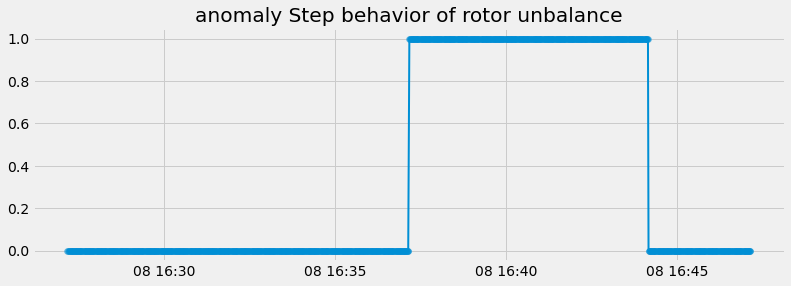

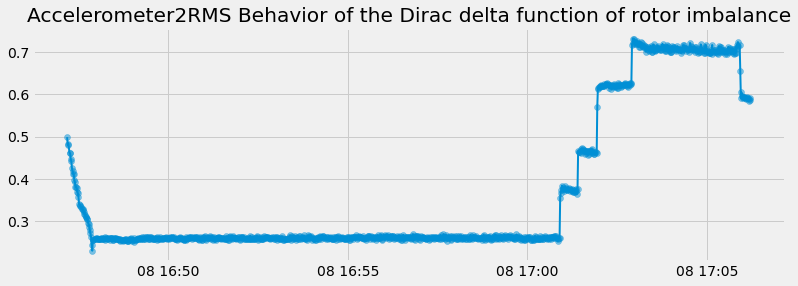

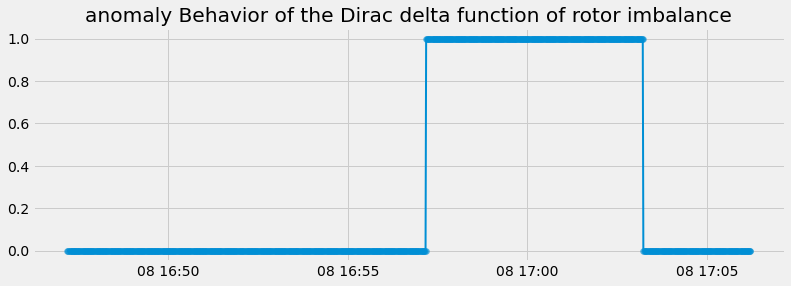

In [57]:
for experiment in range(24, 27):
    fast_plot(dfs[experiment]['Accelerometer2RMS'], title='Accelerometer2RMS ' + 
              summary_table.loc[experiment, 'description'] )
    fast_plot(dfs[experiment]['anomaly'], title='anomaly ' + summary_table.loc[experiment, 'description'] )

The plot of vibration acceleration for the case "Behavior of the Dirac delta function of the rotor unbalance" is more like a step.

It is required to double-check the correctness of the data in the pivot table

Load and draw charts from the following files:
15.csv - Staggered behavior of rotor unbalance
16.csv - Behavior of the rotor unbalance Dirac delta function

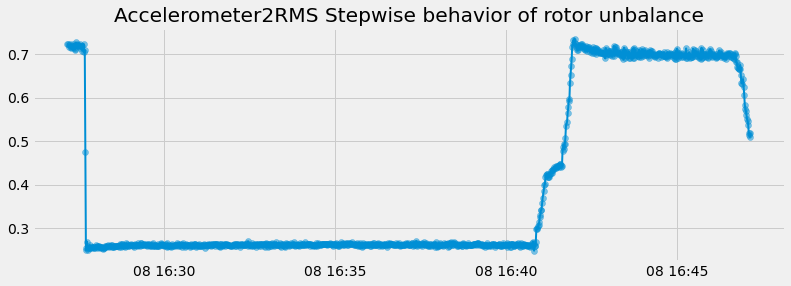

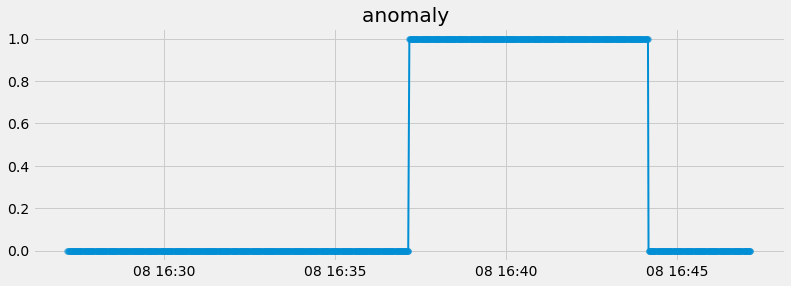

In [58]:
data = pd.read_csv('../data/other/15.csv', sep=';',
                   index_col='datetime', parse_dates=True)
fast_plot(data['Accelerometer2RMS'], title='Accelerometer2RMS Stepwise behavior of rotor unbalance'  )
fast_plot(data['anomaly'], title='anomaly ')

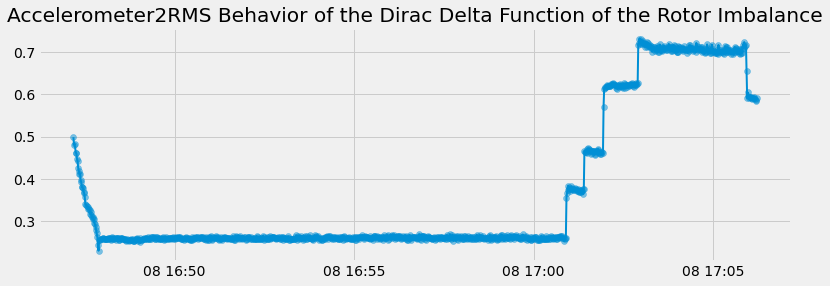

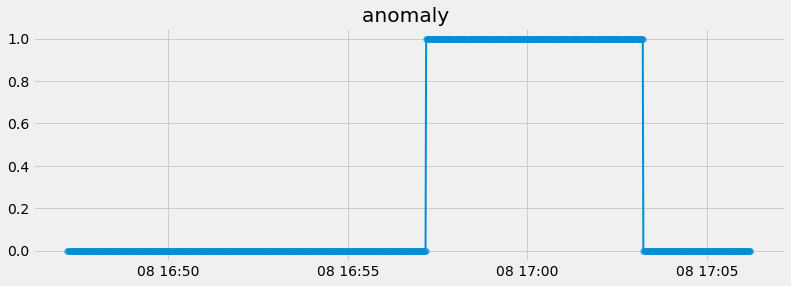

In [59]:
data = pd.read_csv('../data/other/16.csv', sep=';', index_col='datetime', parse_dates=True)
fast_plot(data['Accelerometer2RMS'], title='Accelerometer2RMS Behavior of the Dirac Delta Function of the Rotor Imbalance')
fast_plot(data['anomaly'], title='anomaly ')

Посмотрим на случаи, связанные с падением расхода на дату 2020-02-08

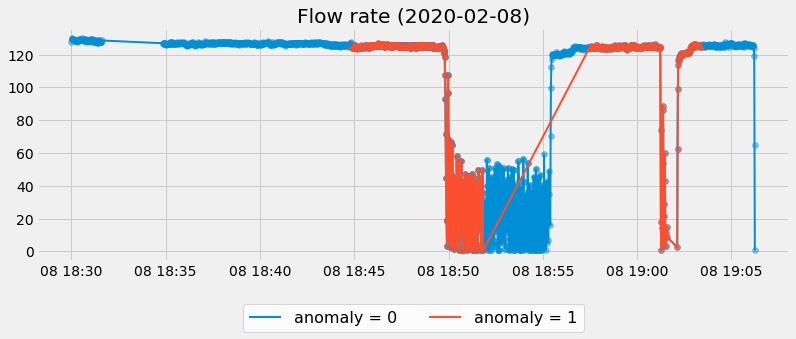

In [60]:
fast_plot(alldata['Volume Flow RateRMS']['2020-02-08 18:30': '2020-02-08 19:15'], title='Flow rate (2020-02-08)',
          label='anomaly = 0')
mask = alldata['anomaly']['2020-02-08 18:30': '2020-02-08 19:15'] == 1
fast_plot(alldata['Volume Flow RateRMS']['2020-02-08 18:30': '2020-02-08 19:15'][mask], new_figure=False,
          label='anomaly = 1')
fast_legend();

> __Hypothesis:__
> * The data is not valid - the markup is not correct, the descriptions of the cases are not correct. A discussion is required with the data provider about this hypothesis and about the possibility of correcting the data.
> * Perhaps the time shift is constant about 3-5 minutes (out of sync between the time in the collection system and the time by which the personnel who conducted the experiment took notes)

<a id="2.4"></a>
## 2.4 (NOT REQUIRED!) Assignment for self-study
* Analyze the remaining features
* Conduct analysis of target variables
* Supplement summary with data description
* Suggest what features can be added to the model for training __*__

<a id="3"></a>
#3 Summary

> __Description of data:__
> * ... (for independent work)

> __Backlog:__
> * Obtain from the customer / find in the documentation a description of the following experiments:
    * 'data/other/11.csv',
    * 'data/other/12.csv',
    * 'data/other/23.csv',
    * 'data/other/9.csv'
> * Add a correction function for current and voltage values ​​to data preprocessing
> * Add filtering by current, voltage, consumption, and vibration accelerations to data preprocessing
> * According to many parameters, there is noise in the signal, it is necessary to choose methods to combat noise (filtering, smoothing ...)
> * A discussion is required with the data provider about the validity of the data and about the possibility of correcting these data.


> __Questions from the customer (if there is no information in the documentation):__
> * At what points is vibration acceleration measured?
> * What can drawdowns in terms of flow rate and vibration accelerations be associated with?
> * What could be the reason for the substitution of current and voltage values? Can be corrected?
> * What is a changepoint and how are they related to anomalies?
> * How many operating modes can there be?
> * What parameters determine the operating modes?
> * How is the flow regulated? Closing valves + current?
> * When are flow signals rounded off?


> __Hypotheses:__
> * Periods with a drop in flow in the anomaly_free dataset must be excluded from the dataset when training models
> * There are experiments in which large gaps in the data are observed right before the start of the anomaly. It is worth removing such experiments from the training and test sets.
> * Since the parameters for different modes of operation vary greatly, it is necessary to add the mode of operation as a feature to the selections when training and inferencing models
> * A decrease in flow (within one mode of operation) often indicates the onset of an anomaly
> * Since the correlation of vibration acceleration values ​​is very close to 1, the values ​​are close and measure the same parameters, it would be a good option to choose 1 of the two signs, and replace the second one with the difference between these two parameters
> * The data is not valid - the markup is not correct, the descriptions of the cases are not correct. A discussion is required with the data provider about this hypothesis and about the possibility of correcting the data.
> * Perhaps the time shift is constant about 3-5 minutes (out of sync between the time in the collection system and the time by which the personnel who conducted the experiment took notes)